# Capstone Project: Sales Forecasting

## Objective:

Building a forecasting model to forecast the daily sales for the next six weeks for Rossmann. 
Only stores, numbered 1,3,8,9,13,25,29,31 and 46, are key for the company keeping in mind the revenue and historical prestige associated with them; therefore, they are part of the sales forecasting capstone project.

## Steps:

The following steps are considered while undertaking the project.

1. Find outliers at the 99th percentile and remove them.

2. Standardize the sales and number of customers variables before modelling.

3. Determine if the data is stationary

4. If stationary then apply Vector Autoregression Model.

5. If non-stationary then specify the model in differences

6. Make sales, promo2 and any other variables as dependent variables.

7. Check for cointegration using the Johansen test. 

8. Predict sales for the next 6 weeks.

## Store 1
[Go to Store 1](#store1)

## Store 3
[Go to Store 3](#store3)

## Store 8
[Go to Store 8](#store8)

## Store 9
[Go to Store 9](#store9)

## Store 13
[Go to Store 13](#store13)

## Store 25
[Go to Store 25](#store25)

## Store 29
[Go to Store 29](#store29)

## Store 31
[Go to Store 31](#store31)

## Store 46
[Go to Store 46](#store46)


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

print(np.__version__)
print(pd.__version__)
print(sm.__version__)
print(sklearn.__version__)

from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.preprocessing import StandardScaler

1.22.4
1.4.1
0.13.5
1.0.2


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
raw_data = pd.read_csv('Dataset/train.csv')
raw_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [4]:
store_data = pd.read_csv('Dataset/store.csv')
store_data

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [5]:
#selecting only the nine-stores stated by the management
nine_stores = [1, 3, 8, 9, 13, 25, 29, 31, 46]
data = raw_data[raw_data['Store'].isin(nine_stores)]
                                       
# merging                                    
data = data.merge(store_data, on='Store', how='left')
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.set_index('Date')
data

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2015-07-31,3,5,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2015-07-31,8,5,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
2015-07-31,9,5,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
2015-07-31,13,5,8821,568,1,1,0,0,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-01,13,2,0,0,0,0,a,1,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
2013-01-01,25,2,0,0,0,0,a,1,c,a,430.0,4.0,2003.0,0,NaN,NaN,NaN
2013-01-01,29,2,0,0,0,0,a,1,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN


In [6]:
print("Missing values check")
print(data.isna().sum())
print("-----")
print(data.dtypes)

Missing values check
Store                           0
DayOfWeek                       0
Sales                           0
Customers                       0
Open                            0
Promo                           0
StateHoliday                    0
SchoolHoliday                   0
StoreType                       0
Assortment                      0
CompetitionDistance             0
CompetitionOpenSinceMonth    1700
CompetitionOpenSinceYear     1700
Promo2                          0
Promo2SinceWeek              5652
Promo2SinceYear              5652
PromoInterval                5652
dtype: int64
-----
Store                          int64
DayOfWeek                      int64
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionD

In [7]:
# cleaning the data for StateHoliday
data.loc[:,'StateHoliday'] = data['StateHoliday'].apply(lambda x: 1 if x == '0' or x == 0 else 0)

In [8]:
data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,8110.000000,8110.000000,8110.000000,8110.000000,8110.000000,8110.000000,8110.000000,8110.000000,8110.000000,6410.000000,6410.000000,8110.000000,2458.000000,2458.000000
mean,17.826634,3.998520,5394.031566,590.330210,0.823798,0.381258,0.969297,0.177435,4479.442663,8.412168,2006.910452,0.303083,23.559805,2010.383238
std,13.989612,1.997532,3455.976814,421.269874,0.381016,0.485726,0.172522,0.382060,4714.857046,2.352367,4.603190,0.459619,14.319480,0.923837
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,310.000000,4.000000,2000.000000,0.000000,14.000000,2009.000000
25%,8.000000,2.000000,3792.250000,421.000000,1.000000,0.000000,1.000000,0.000000,1200.000000,7.000000,2003.000000,0.000000,14.000000,2009.000000
50%,13.000000,4.000000,5406.000000,573.000000,1.000000,0.000000,1.000000,0.000000,2030.000000,9.000000,2006.000000,0.000000,14.000000,2011.000000
75%,29.000000,6.000000,7252.500000,720.000000,1.000000,1.000000,1.000000,0.000000,7520.000000,10.000000,2012.000000,1.000000,45.000000,2011.000000
max,46.000000,7.000000,24882.000000,2835.000000,1.000000,1.000000,1.000000,1.000000,14130.000000,12.000000,2014.000000,1.000000,45.000000,2011.000000


### Note

I conducted a visual inspection on the "store.csv" file with MS Excel and I realized that there is no datetime associated with Promo2 and the other variables. 
I would like variables that vary with the datetime and therefore, I have chosen to exclude "store.csv" and its variables from this analysis

In [9]:
from datetime import date
from dateutil.relativedelta import relativedelta

start_date = raw_data.index[-1]
end_date = raw_data.index[0]

def date_test(df):
    return pd.date_range(start = start_date, end = end_date).difference(df.index)

date_test(data)

# python calculate 6 weeks ago from today
six_weeks = data.index[0] + relativedelta(weeks = -6)
print(six_weeks) # the 6 weeks that we will use for the train and validation dataset

#test set of next 6 weeks
test_index = data.index[0] + relativedelta(weeks = 6)
print(test_index) #this will be 6 weeks that are of the data range that we are trying to predict

2015-06-19 00:00:00
2015-09-11 00:00:00


In [10]:
#HELPER FUNCTIONS

#train test split function
def ts_train_test_split(df, period):
    train = df[df.index < period]
    test = df[df.index >= period] 
    
    return train, test

#johansen integration test function
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1], index=['max_eig_stat',"trace_stat"])
    rank = np.linalg.matrix_rank(output)
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')
    print("Rank of matrix,",rank)

<a id="store1"></a>
### Store 1 Analysis & Predictions

Below are the analysis and predictions for store 1

In [11]:
df = data[data['Store'] == 1] #filtering out for store 1 data
df = df.asfreq('D')

Text(0.5, 1.0, 'Daily Sales')

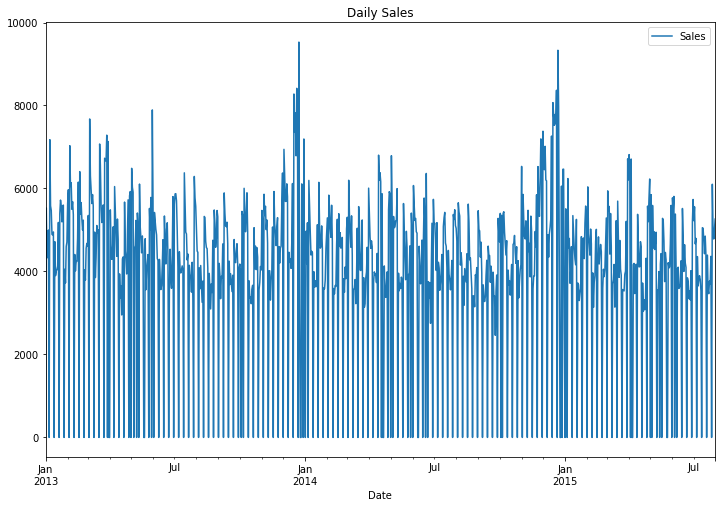

In [12]:
df['Sales'].plot(figsize=(12, 8))
plt.legend(loc='best' )
plt.title('Daily Sales')

Text(0.5, 1.0, 'Daily Customers')

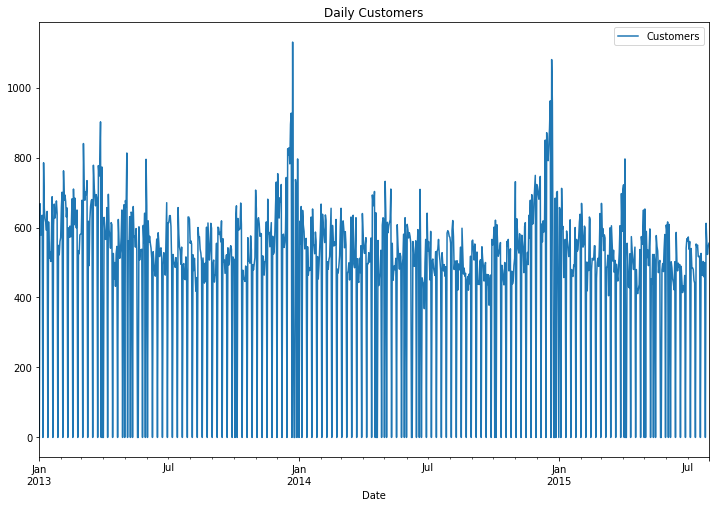

In [13]:
df['Customers'].plot(figsize=(12, 8))
plt.legend(loc='best' )
plt.title('Daily Customers')

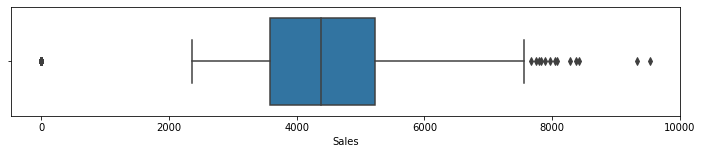

In [14]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x = df['Sales'], whis=1.5)

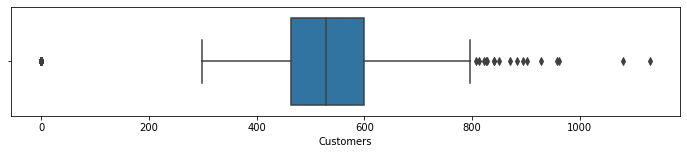

In [15]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x = df['Customers'], whis=1.5)

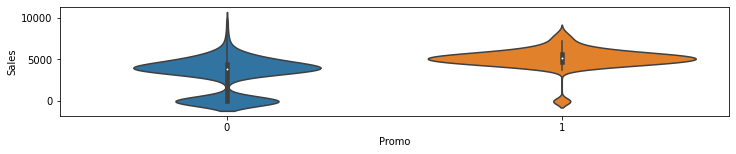

In [16]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.violinplot(data=df, x= "Promo", y="Sales")

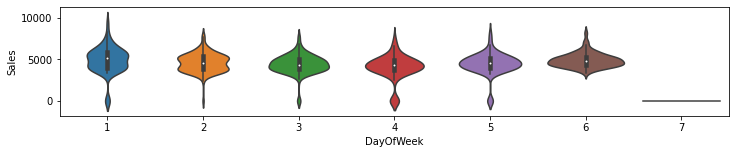

In [17]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.violinplot(data=df, x= "DayOfWeek", y="Sales")

Two observations from the above plots:
1. There are outliers that have to be removed as per instructions
2. I will be using 'Open', 'Promo', and 'DayOfWeek' columns as default exogenous variables as I believe that these will have an impact for all the 9 models.
3. However, I will be removing some of the exogenous variables if the model fails to produce a good result. 

Text(0.5, 1.0, 'Sales data with outliers removed')

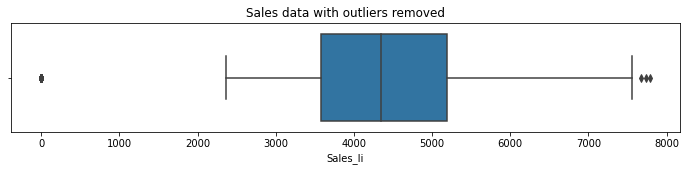

In [18]:
# removal of outliers above 99 percentile
p = np.percentile(df['Sales'], 99)

df[['Sales_li', 'Customers_li']] = df[['Sales', 'Customers']].copy()

# replace the sales and customers data for outliers point with NaN values
for col in df[['Sales_li', 'Customers_li']]:
    df[col] =  np.where(df[col] >= p, np.nan, df[col])

fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x = df['Sales_li'], whis=1.5)
plt.title('Sales data with outliers removed')

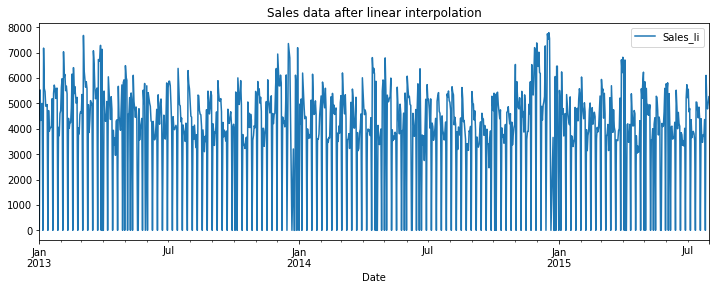

In [19]:
df = df.assign(Sales_li = df['Sales_li'].interpolate(method='linear')) #using interpolation to fill nan values for sales
df[['Sales_li']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales data after linear interpolation')
plt.show(block=False)

In [20]:
df = df.assign(Customers_li = df['Customers_li'].interpolate(method='linear')) #using interpolation to fill nan values for customers

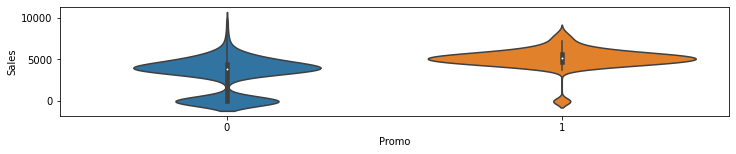

In [21]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.violinplot(data=df, x= "Promo", y="Sales")

In [22]:
# using ADF test to check for stationarity
adf_test = adfuller(df['Sales_li'])

print("ADF Statistic for Sales: {:.2f}".format(adf_test[0]))
print("p-value for Sales: {:.2f}".format(adf_test[1]))

# using ADF test to check for stationarity
adf_test = adfuller(df['Customers_li'])

print("ADF Statistic for Customers: {:.2f}".format(adf_test[0]))
print("p-value for Customers: {:.2f}".format(adf_test[1]))

ADF Statistic for Sales: -5.24
p-value for Sales: 0.00
ADF Statistic for Customers: -3.70
p-value for Customers: 0.00


The p-value is less than .05, we reject the null hypothesis of the ADF test.
We can assume that the trend is stationary.

In [23]:
train, test = ts_train_test_split(df, period = six_weeks)
print(train.shape)
print(test.shape)

(899, 19)
(43, 19)


In [24]:
# scaling the data that have outliers removed
sales_scaler = StandardScaler()
train['Sales_li'] = sales_scaler.fit_transform(train[['Sales_li']])
test['Sales_li'] = sales_scaler.fit_transform(test[['Sales_li']])

customer_scaler = StandardScaler()

train['Customers_li'] = customer_scaler.fit_transform(train[['Customers_li']])
test['Customers_li'] = customer_scaler.fit_transform(test[['Customers_li']])

In [25]:
#running var model
mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(3,0), trend='n')
var_res = mod.fit(maxiter=1000, disp=False)
print(var_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Sales_li', 'Customers_li']   No. Observations:                  899
Model:                                   VAR(3)   Log Likelihood               -1424.983
Date:                          Wed, 01 Feb 2023   AIC                           2879.966
Time:                                  17:56:31   BIC                           2951.985
Sample:                              01-01-2013   HQIC                          2907.479
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):             0.02, 0.01   Jarque-Bera (JB):     92.28, 104851.87
Prob(Q):                        0.89, 0.91   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.07, 2.75   Skew:                      -0.78, 5.20
Prob(H) (two-sided):            0.56

In [26]:
joh_model = coint_johansen(df[['Customers_li','Sales_li']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model)

   max_eig_stat  trace_stat
0    189.839358  225.978890
1     36.139532   36.139532 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank of matrix, 2


In [27]:
# running VAR/VARMAX model due to rank of matrix being 2
exog = train[['Promo','Open','DayOfWeek']] 
mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(1,1), trend='n',exog=exog)
varmax_res = mod.fit(maxiter=1000, disp=False)
print(varmax_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Sales_li', 'Customers_li']   No. Observations:                  899
Model:                              VARMAX(1,1)   Log Likelihood                -720.863
Date:                          Wed, 01 Feb 2023   AIC                           1475.726
Time:                                  17:58:31   BIC                           1557.348
Sample:                              01-01-2013   HQIC                          1506.908
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):           17.51, 40.41   Jarque-Bera (JB):    276.54, 155439.86
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.36, 2.50   Skew:                      -0.50, 6.34
Prob(H) (two-sided):            0.01

In [28]:
# simple search to find the p for the model based on AIC value
# due to time and resources constraint, I will only be looping through p with the same three exogenous vars

p = 3

mod_list, aic_list = [], []
for i in range(1, p + 1):
    print("p : {}".format(i))
    mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(i,1), trend='n',exog=exog)
    varmax_res = mod.fit(maxiter=1000, disp=False)
    print("AIC : {}".format(varmax_res.aic))
    
    aic_list.append(varmax_res.aic)
    mod_list.append(varmax_res)
    
varmax_res = mod_list[np.argmin(aic_list)] # model with lowest AIC value

p : 1
AIC : 1475.7260902721437
p : 2
AIC : 1444.4302796928123
p : 3
AIC : 1365.7457543170344


In [29]:
start_index = test.index[0]
end_index = test.index[-1]
pred_var = var_res.predict(start=start_index, end=end_index)
pred_varmax = varmax_res.predict(start=start_index, end=end_index, exog= test[['Promo','Open','DayOfWeek']])

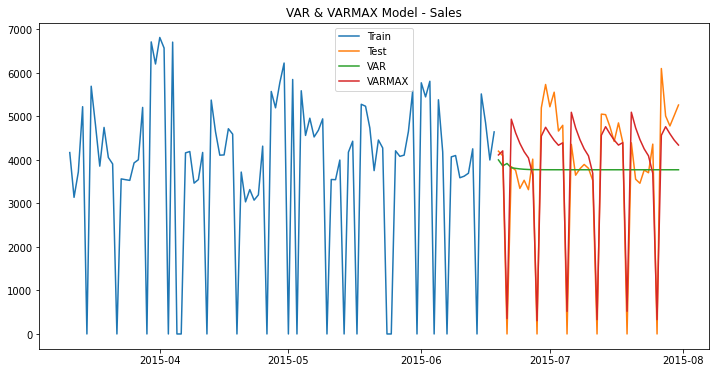

In [30]:
df_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(pred_varmax[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)
df_pred_var = pd.DataFrame(sales_scaler.inverse_transform(pred_var[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)

# visualizing the data generated for the next 6 weeks
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(df_pred_var['Sales_li'], label='VAR')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales')
plt.show()

In [31]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_var.Sales_li)).round(2)

model_comparison=pd.DataFrame()
model_comparison.loc[0,'Model']='VAR'
model_comparison.loc[0,'Variable']='Sales'
model_comparison.loc[0,'RMSE']=rmse

rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_varmax.Sales_li)).round(2)

append=pd.DataFrame()
append.loc[1,'Model']='VARMAX'
append.loc[1,'Variable']='Sales'
append.loc[1,'RMSE']=rmse

model_comparison = model_comparison.append(append)

rmse = np.sqrt(mean_squared_error(test.Customers_li, pred_varmax.Customers_li)).round(2)

append=pd.DataFrame()
append.loc[2,'Model']='VARMAX'
append.loc[2,'Variable']='Customers'
append.loc[2,'RMSE']=rmse

model_comparison = model_comparison.append(append)

# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(test.Sales_li, pred_var.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VAR'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Sales_li, pred_varmax.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Customers_li, pred_varmax.Customers_li).round(2)

model_comparison.loc[(model_comparison['Variable']=='Customers') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape
mape = "{:.2f}".format(mape)
print(model_comparison)

    Model   Variable  RMSE  MAPE
0     VAR      Sales  1.00  1.03
1  VARMAX      Sales  0.40  5.81
2  VARMAX  Customers  0.38   2.1


RMSE (normalized) and MAPE for the VARMAX on Sales as above. The performance of both RMSE and MAPE could have been better with lower AIC and BIC values in the models.

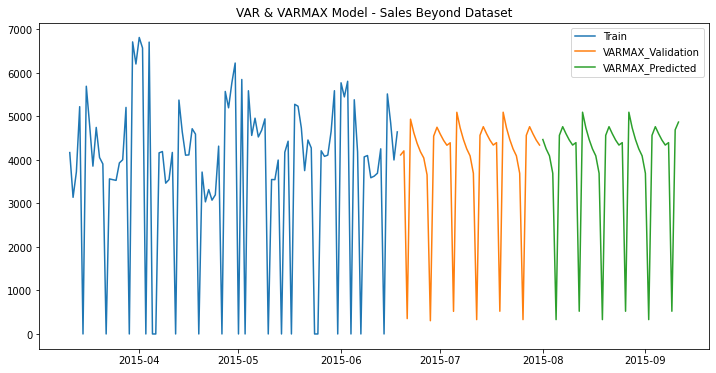

In [32]:
# Predict future values
prediction = varmax_res.forecast(steps=train.shape[0], exog=train[['Promo','Open','DayOfWeek']])

df_test_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(prediction[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(prediction.index)
df_test_pred_varmax = df_test_pred_varmax.loc[end_index+relativedelta(days=1):test_index]

# visualizing the data generated for the next 6 weeks BEYOND the dataset
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX_Validation')
plt.plot(df_test_pred_varmax['Sales_li'], label='VARMAX_Predicted')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales Beyond Dataset')
plt.show()

<a id="store3"></a>
### Store 3 Analysis & Predictions

In [33]:
df = data[data['Store'] == 3] # pulling out data for store 3
df = df.asfreq('D')

In [34]:
# removal of outliers above 99 percentile
p = np.percentile(df['Sales'], 99)

df[['Sales_li', 'Customers_li']] = df[['Sales', 'Customers']].copy()

# replace the sales and customers data for outliers point with NaN values
for col in df[['Sales_li', 'Customers_li']]:
    df[col] =  np.where(df[col] >= p, np.nan, df[col])

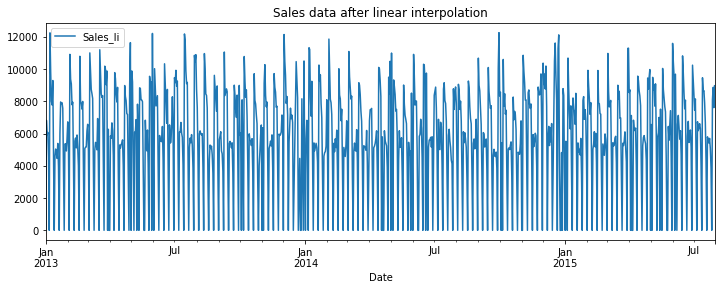

In [35]:
df = df.assign(Sales_li = df['Sales_li'].interpolate(method='linear')) #using interpolation to fill nan values for sales
df = df.assign(Customers_li = df['Customers_li'].interpolate(method='linear')) #using interpolation to fill nan values for customers

df[['Sales_li']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales data after linear interpolation')
plt.show(block=False)

In [36]:
# using ADF test to check for stationarity
adf_test = adfuller(df['Sales_li'])

print("ADF Statistic for Sales: {:.2f}".format(adf_test[0]))
print("p-value for Sales: {:.2f}".format(adf_test[1]))

# using ADF test to check for stationarity
adf_test = adfuller(df['Customers_li'])

print("ADF Statistic for Customers: {:.2f}".format(adf_test[0]))
print("p-value for Customers: {:.2f}".format(adf_test[1]))

ADF Statistic for Sales: -6.88
p-value for Sales: 0.00
ADF Statistic for Customers: -5.52
p-value for Customers: 0.00


The p-value is less than .05, we reject the null hypothesis of the ADF test. We can assume that the trend is stationary.

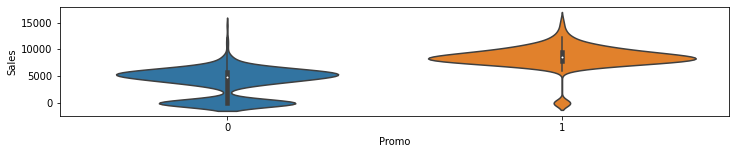

In [37]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.violinplot(data=df, x= "Promo", y="Sales")

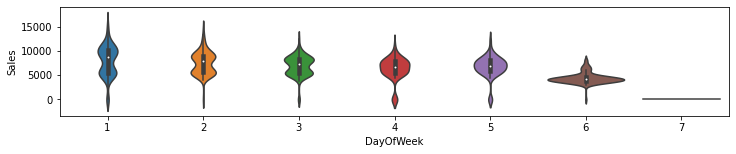

In [38]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.violinplot(data=df, x= "DayOfWeek", y="Sales")

In [39]:
train, test = ts_train_test_split(df, period = six_weeks)
print(train.shape)
print(test.shape)

(899, 19)
(43, 19)


In [40]:
# scaling both sales and customer data
sales_scaler = StandardScaler()
train['Sales_li'] = sales_scaler.fit_transform(train[['Sales_li']])
test['Sales_li'] = sales_scaler.fit_transform(test[['Sales_li']])

customer_scaler = StandardScaler()

train['Customers_li'] = customer_scaler.fit_transform(train[['Customers_li']])
test['Customers_li'] = customer_scaler.fit_transform(test[['Customers_li']])

In [41]:
mod = sm.tsa.VARMAX(train[['Sales_li', 'Customers_li']].astype('float32'), order=(3,0), trend='n')
var_res = mod.fit(maxiter=1000, disp=False)
print(var_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Sales_li', 'Customers_li']   No. Observations:                  899
Model:                                   VAR(3)   Log Likelihood               -1394.595
Date:                          Wed, 01 Feb 2023   AIC                           2819.190
Time:                                  18:15:06   BIC                           2891.209
Sample:                              01-01-2013   HQIC                          2846.704
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):             0.36, 0.00   Jarque-Bera (JB):     10.74, 127351.75
Prob(Q):                        0.55, 0.97   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.05, 1.66   Skew:                      -0.26, 5.07
Prob(H) (two-sided):            0.67

In [42]:
joh_model = coint_johansen(df[['Customers_li','Sales_li']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model)

   max_eig_stat  trace_stat
0    208.609076  258.925572
1     50.316497   50.316497 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank of matrix, 2


In [43]:
# running VAR/VARMAX model due to rank of matrix being 2
exog = train[['Promo','Open','DayOfWeek']]
mod = sm.tsa.VARMAX(train[['Sales_li', 'Customers_li']].astype('float32'), order=(1,1), trend='n',exog=exog)
varmax_res = mod.fit(maxiter=1000, disp=False)
print(varmax_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Sales_li', 'Customers_li']   No. Observations:                  899
Model:                              VARMAX(1,1)   Log Likelihood                -575.332
Date:                          Wed, 01 Feb 2023   AIC                           1184.665
Time:                                  18:16:10   BIC                           1266.286
Sample:                              01-01-2013   HQIC                          1215.846
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):             0.10, 0.48   Jarque-Bera (JB):    432.60, 181949.10
Prob(Q):                        0.75, 0.49   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.06, 1.85   Skew:                      -0.40, 6.11
Prob(H) (two-sided):            0.61

In [44]:
# simple search to find the p for the model based on AIC value
# due to time and resources constraint, I will only be looping through p with the same three exogenous vars

p = 3

mod_list, aic_list = [], []
for i in range(1, p + 1):
    print("p : {}".format(i))
    mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(i,1), trend='n',exog=exog)
    varmax_res = mod.fit(maxiter=1000, disp=False)
    print("AIC : {}".format(varmax_res.aic))
    
    aic_list.append(varmax_res.aic)
    mod_list.append(varmax_res)
    
varmax_res = mod_list[np.argmin(aic_list)] # model with lowest AIC value

p : 1
AIC : 1184.6646474800505
p : 2
AIC : 1136.9268475013478
p : 3
AIC : 1061.901352531565


In [45]:
start_index = test.index[0]
end_index = test.index[-1]
pred_var = var_res.predict(start=start_index, end=end_index)
pred_varmax = varmax_res.predict(start=start_index, end=end_index, exog= test[['Promo','Open','DayOfWeek']] )

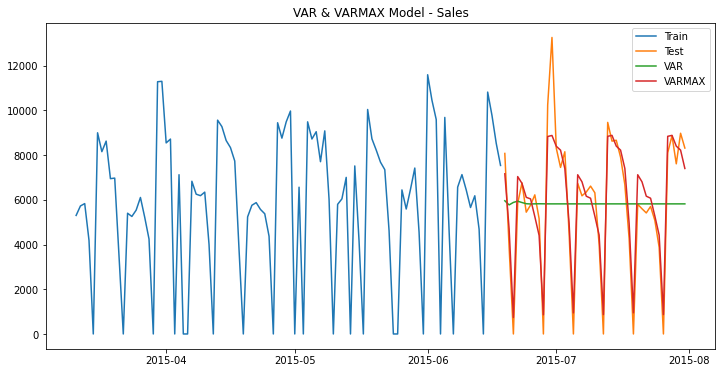

In [51]:
df_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(pred_varmax[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)
df_pred_var = pd.DataFrame(sales_scaler.inverse_transform(pred_var[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)

# visualizing the data generated for the next 6 weeks
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(df_pred_var['Sales_li'], label='VAR')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales')
plt.show()

In [52]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_var.Sales_li)).round(2)

model_comparison=pd.DataFrame()
model_comparison.loc[0,'Model']='VAR'
model_comparison.loc[0,'Variable']='Sales'
model_comparison.loc[0,'RMSE']=rmse

rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_varmax.Sales_li)).round(2)

append=pd.DataFrame()
append.loc[1,'Model']='VARMAX'
append.loc[1,'Variable']='Sales'
append.loc[1,'RMSE']=rmse

model_comparison = model_comparison.append(append)

rmse = np.sqrt(mean_squared_error(test.Customers_li, pred_varmax.Customers_li)).round(2)

append=pd.DataFrame()
append.loc[2,'Model']='VARMAX'
append.loc[2,'Variable']='Customers'
append.loc[2,'RMSE']=rmse

model_comparison = model_comparison.append(append)

# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(test.Sales_li, pred_var.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VAR'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Sales_li, pred_varmax.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Customers_li, pred_varmax.Customers_li).round(2)

model_comparison.loc[(model_comparison['Variable']=='Customers') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape
mape = "{:.2f}".format(mape)
print(model_comparison)

    Model   Variable  RMSE  MAPE
0     VAR      Sales  1.00  1.08
1  VARMAX      Sales  0.26  3.57
2  VARMAX  Customers  0.30  0.72


RMSE and MAPE for the VARMAX on Sales as above. AIC and BIC values could be much lower for a better fit model which can also produce lower RMSE values.

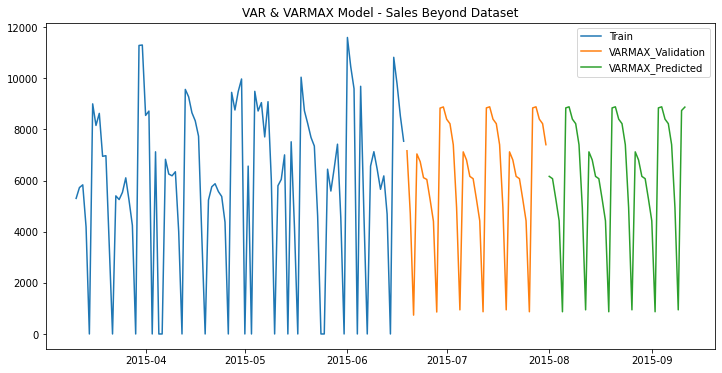

In [53]:
# Predict future values
prediction = varmax_res.forecast(steps=train.shape[0], exog=train[['Promo','Open','DayOfWeek']])

df_test_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(prediction[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(prediction.index)
df_test_pred_varmax = df_test_pred_varmax.loc[end_index+relativedelta(days=1):test_index]

# visualizing the data generated for the next 6 weeks BEYOND the dataset
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX_Validation')
plt.plot(df_test_pred_varmax['Sales_li'], label='VARMAX_Predicted')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales Beyond Dataset')
plt.show()

<a id="store8"></a>
### Store 8 Analysis & Predictions

In [54]:
df = data[data['Store'] == 8]
df = df.asfreq('D')

The p-value is less than .05, we reject the null hypothesis of the ADF test. We can assume that the trend is stationary.

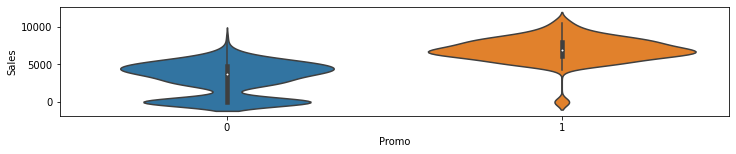

In [55]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.violinplot(data=df, x= "Promo", y="Sales")

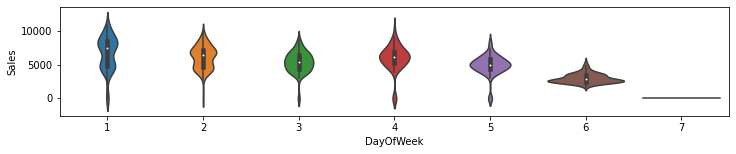

In [56]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.violinplot(data=df, x= "DayOfWeek", y="Sales")

In [57]:
# removal of outliers above 99 percentile
p = np.percentile(df['Sales'], 99)

df[['Sales_li', 'Customers_li']] = df[['Sales', 'Customers']].copy()

# replace the sales and customers data for outliers point with NaN values
for col in df[['Sales_li', 'Customers_li']]:
    df[col] =  np.where(df[col] >= p, np.nan, df[col])

df = df.assign(Sales_li = df['Sales_li'].interpolate(method='linear')) #using interpolation to fill nan values for sales
df = df.assign(Customers_li = df['Customers_li'].interpolate(method='linear')) #using interpolation to fill nan values for customers

In [58]:
# using ADF test to check for stationarity
adf_test = adfuller(df['Sales_li'])

print("ADF Statistic for Sales: {:.2f}".format(adf_test[0]))
print("p-value for Sales: {:.2f}".format(adf_test[1]))

# using ADF test to check for stationarity
adf_test = adfuller(df['Customers_li'])

print("ADF Statistic for Customers: {:.2f}".format(adf_test[0]))
print("p-value for Customers: {:.2f}".format(adf_test[1]))

ADF Statistic for Sales: -3.82
p-value for Sales: 0.00
ADF Statistic for Customers: -3.99
p-value for Customers: 0.00


In [59]:
train, test = ts_train_test_split(df, period = six_weeks)
print(train.shape)
print(test.shape)

(899, 19)
(43, 19)


In [60]:
# scaling both sales and customer data

sales_scaler = StandardScaler()
train['Sales_li'] = sales_scaler.fit_transform(train[['Sales_li']])
test['Sales_li'] = sales_scaler.fit_transform(test[['Sales_li']])

customer_scaler = StandardScaler()

train['Customers_li'] = customer_scaler.fit_transform(train[['Customers_li']])
test['Customers_li'] = customer_scaler.fit_transform(test[['Customers_li']])

In [61]:
mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(3,0), trend='n')
var_res = mod.fit(maxiter=1000, disp=False)
print(var_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Sales_li', 'Customers_li']   No. Observations:                  899
Model:                                   VAR(3)   Log Likelihood               -1308.613
Date:                          Wed, 01 Feb 2023   AIC                           2647.225
Time:                                  18:32:42   BIC                           2719.245
Sample:                              01-01-2013   HQIC                          2674.739
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):             0.11, 0.07   Jarque-Bera (JB):       0.28, 12696.90
Prob(Q):                        0.74, 0.79   Prob(JB):                   0.87, 0.00
Heteroskedasticity (H):         1.53, 3.66   Skew:                      -0.00, 2.67
Prob(H) (two-sided):            0.00

In [62]:
joh_model = coint_johansen(df[['Customers_li','Sales_li']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model)

   max_eig_stat  trace_stat
0    278.489861  331.279550
1     52.789689   52.789689 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank of matrix, 2


In [63]:
# running VAR/VARMAX model due to rank of matrix being 2
exog = train[['Promo','Open','DayOfWeek']]
mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(1,1), trend='n',exog=exog)
varmax_res = mod.fit(maxiter=1000, disp=False)
print(varmax_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Sales_li', 'Customers_li']   No. Observations:                  899
Model:                              VARMAX(1,1)   Log Likelihood                -432.708
Date:                          Wed, 01 Feb 2023   AIC                            899.415
Time:                                  18:35:22   BIC                            981.037
Sample:                              01-01-2013   HQIC                           930.597
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):             0.00, 0.00   Jarque-Bera (JB):     232.63, 26738.33
Prob(Q):                        0.95, 0.98   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.55, 4.19   Skew:                      -0.47, 3.61
Prob(H) (two-sided):            0.00

In [64]:
# simple search to find the p for the model based on AIC value
# due to time and resources constraint, I will only be looping through p with the same three exogenous vars

p = 3

mod_list, aic_list = [], []
for i in range(1, p + 1):
    print("p : {}".format(i))
    mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(i,1), trend='n',exog=exog)
    varmax_res = mod.fit(maxiter=1000, disp=False)
    print("AIC : {}".format(varmax_res.aic))
    
    aic_list.append(varmax_res.aic)
    mod_list.append(varmax_res)
    
varmax_res = mod_list[np.argmin(aic_list)] # model with lowest AIC value

p : 1
AIC : 899.4154728070284
p : 2
AIC : 697.8357313914166
p : 3
AIC : 629.9433927562208


In [65]:
start_index = test.index[0]
end_index = test.index[-1]
pred_var = var_res.predict(start=start_index, end=end_index)
pred_varmax = varmax_res.predict(start=start_index, end=end_index, exog= test[['Promo','Open','DayOfWeek']])

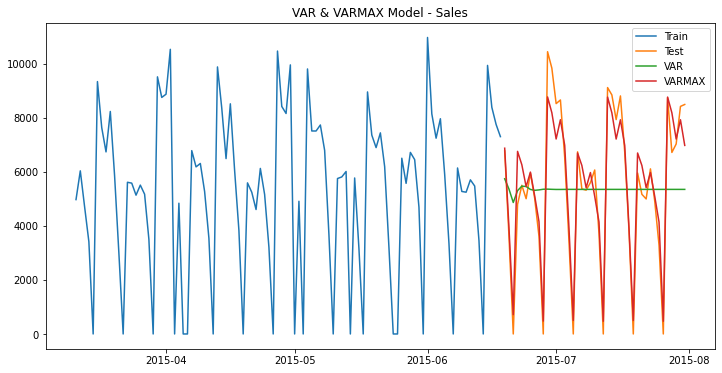

In [66]:
df_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(pred_varmax[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)
df_pred_var = pd.DataFrame(sales_scaler.inverse_transform(pred_var[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)

# visualizing the data generated for the next 6 weeks
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(df_pred_var['Sales_li'], label='VAR')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales')
plt.show()

In [67]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_var.Sales_li)).round(2)

model_comparison=pd.DataFrame()
model_comparison.loc[0,'Model']='VAR'
model_comparison.loc[0,'Variable']='Sales'
model_comparison.loc[0,'RMSE']=rmse

rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_varmax.Sales_li)).round(2)

append=pd.DataFrame()
append.loc[1,'Model']='VARMAX'
append.loc[1,'Variable']='Sales'
append.loc[1,'RMSE']=rmse

model_comparison = model_comparison.append(append)

rmse = np.sqrt(mean_squared_error(test.Customers_li, pred_varmax.Customers_li)).round(2)

append=pd.DataFrame()
append.loc[2,'Model']='VARMAX'
append.loc[2,'Variable']='Customers'
append.loc[2,'RMSE']=rmse

model_comparison = model_comparison.append(append)

# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(test.Sales_li, pred_var.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VAR'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Sales_li, pred_varmax.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Customers_li, pred_varmax.Customers_li).round(2)

model_comparison.loc[(model_comparison['Variable']=='Customers') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape
mape = "{:.2f}".format(mape)
print(model_comparison)

    Model   Variable  RMSE  MAPE
0     VAR      Sales  0.99  0.98
1  VARMAX      Sales  0.34  2.26
2  VARMAX  Customers  0.26  0.85


RMSE and MAPE for the VARMAX on Sales as above. AIC and BIC values could be much lower for a better fit model which can also produce lower RMSE values.

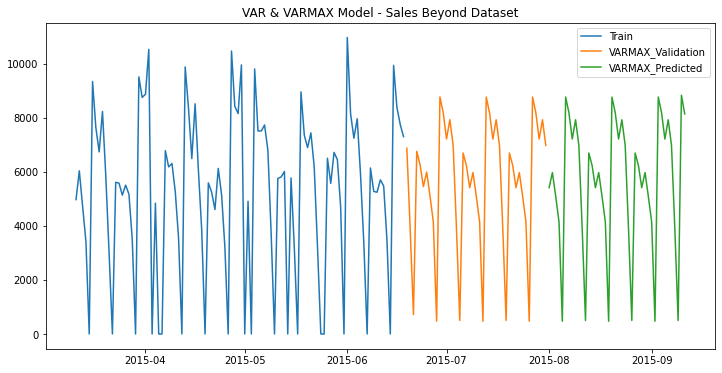

In [68]:
# Predict future values
prediction = varmax_res.forecast(steps=train.shape[0], exog=train[['Promo','Open','DayOfWeek']])

df_test_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(prediction[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(prediction.index)
df_test_pred_varmax = df_test_pred_varmax.loc[end_index+relativedelta(days=1):test_index]

# visualizing the data generated for the next 6 weeks BEYOND the dataset
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX_Validation')
plt.plot(df_test_pred_varmax['Sales_li'], label='VARMAX_Predicted')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales Beyond Dataset')
plt.show()

### Store 9 Analysis & Predictions

In [331]:
df = data[data['Store'] == 9]
df = df.asfreq('D')

In [332]:
# removal of outliers above 99 percentile
p = np.percentile(df['Sales'], 99)

df[['Sales_li', 'Customers_li']] = df[['Sales', 'Customers']].copy()

# replace the sales and customers data for outliers point with NaN values
for col in df[['Sales_li', 'Customers_li']]:
    df[col] =  np.where(df[col] >= p, np.nan, df[col])

df = df.assign(Sales_li = df['Sales_li'].interpolate(method='linear')) #using interpolation to fill nan values for sales
df = df.assign(Customers_li = df['Customers_li'].interpolate(method='linear')) #using interpolation to fill nan values for customers

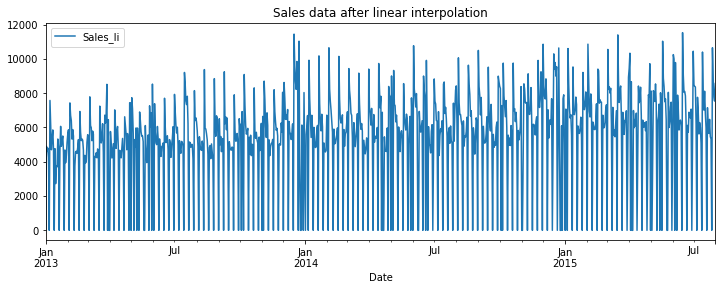

In [333]:
df[['Sales_li']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales data after linear interpolation')
plt.show(block=False)

In [334]:
# using ADF test to check for stationarity
adf_test = adfuller(df['Sales_li'])

print("ADF Statistic for Sales: {:.2f}".format(adf_test[0]))
print("p-value for Sales: {:.2f}".format(adf_test[1]))

# using ADF test to check for stationarity
adf_test = adfuller(df['Customers_li'])

print("ADF Statistic for Customers: {:.2f}".format(adf_test[0]))
print("p-value for Customers: {:.2f}".format(adf_test[1]))

ADF Statistic for Sales: -3.27
p-value for Sales: 0.02
ADF Statistic for Customers: -3.29
p-value for Customers: 0.02


The p-value is less than .05, we reject the null hypothesis of the ADF test. We can assume that the trend is stationary.

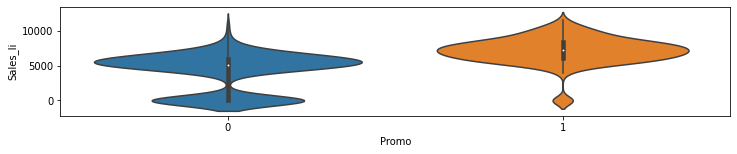

In [335]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.violinplot(data=df, x= "Promo", y="Sales_li")

In [336]:
train, test = ts_train_test_split(df, period = six_weeks)
print(train.shape)
print(test.shape)

(899, 19)
(43, 19)


In [337]:
# scaling both customer and sales data
sales_scaler = StandardScaler()
train['Sales_li'] = sales_scaler.fit_transform(train[['Sales_li']])
test['Sales_li'] = sales_scaler.fit_transform(test[['Sales_li']])

customer_scaler = StandardScaler()

train['Customers'] = customer_scaler.fit_transform(train[['Customers']])
test['Customers'] = customer_scaler.fit_transform(test[['Customers']])

In [338]:
mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(1,0), trend='n')
var_res = mod.fit(maxiter=1000, disp=False)
print(var_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Sales_li', 'Customers_li']   No. Observations:                  899
Model:                                   VAR(1)   Log Likelihood               -6508.352
Date:                          Wed, 01 Feb 2023   AIC                          13030.703
Time:                                  23:50:19   BIC                          13064.312
Sample:                              01-01-2013   HQIC                         13043.543
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):           0.03, 198.66   Jarque-Bera (JB):      82.53, 26511.98
Prob(Q):                        0.87, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):        1.69, 11.09   Skew:                     -0.74, -0.44
Prob(H) (two-sided):            0.00

In [339]:
joh_model = coint_johansen(train[['Customers_li','Sales_li']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model)

   max_eig_stat  trace_stat
0    434.241004  436.780100
1      2.539096    2.539096 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank of matrix, 2


In [340]:
# running VAR/VARMAX model due to rank of matrix being 2
# simple search to find the p for the model based on AIC value
# due to time and resources constraint, I will only be looping through p with the same three exogenous vars

p = 3
exog = train[['Promo', 'DayOfWeek', 'Open']]

mod_list, aic_list = [], []
for i in range(1, p + 1):
    print("p : {}".format(i))
    mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(i,1), trend='n',exog=exog)
    varmax_res = mod.fit(maxiter=1000, disp=False)
    print("AIC : {}".format(varmax_res.aic))
    
    aic_list.append(varmax_res.aic)
    mod_list.append(varmax_res)
    
varmax_res = mod_list[np.argmin(aic_list)] # model with lowest AIC value

p : 1
AIC : 12236.621558851333
p : 2
AIC : 13096.960836549684
p : 3
AIC : 12160.603659045279


In [341]:
print(varmax_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Sales_li', 'Customers_li']   No. Observations:                  899
Model:                              VARMAX(3,1)   Log Likelihood               -6055.302
Date:                          Thu, 02 Feb 2023   AIC                          12160.604
Time:                                  00:11:28   BIC                          12280.636
Sample:                              01-01-2013   HQIC                         12206.459
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):            13.31, 3.24   Jarque-Bera (JB):       44.06, 1332.91
Prob(Q):                        0.00, 0.07   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.52, 2.58   Skew:                       0.34, 0.76
Prob(H) (two-sided):            0.00

In [342]:
start_index = test.index[0]
end_index = test.index[-1]
pred_var = var_res.predict(start=start_index, end=end_index)
pred_varmax = varmax_res.predict(start=start_index, end=end_index, exog= test[['Promo', 'DayOfWeek', 'Open']])

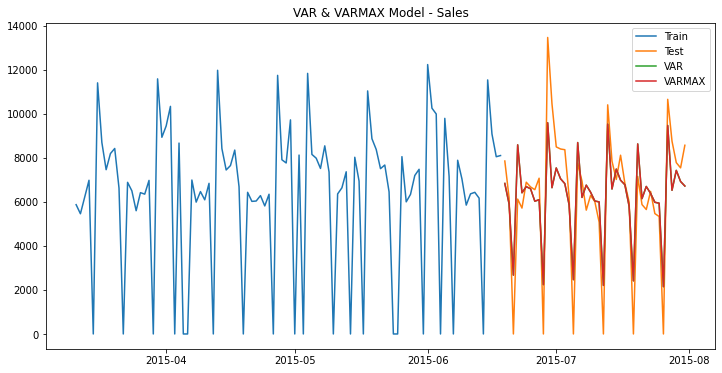

In [343]:
df_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(pred_varmax[['Sales_li']])).rename(columns={0:'Sales'}).set_index(test.index)
df_pred_var = pd.DataFrame(sales_scaler.inverse_transform(pred_var[['Sales_li']])).rename(columns={0:'Sales'}).set_index(test.index)

# visualizing the data generated for the next 6 weeks
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(df_pred_varmax['Sales'], label='VAR')
plt.plot(df_pred_varmax['Sales'], label='VARMAX')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales')
plt.show()

In [344]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_var.Sales_li)).round(2)

model_comparison=pd.DataFrame()
model_comparison.loc[0,'Model']='VAR'
model_comparison.loc[0,'Variable']='Sales'
model_comparison.loc[0,'RMSE']=rmse

rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_varmax.Sales_li)).round(2)

append=pd.DataFrame()
append.loc[1,'Model']='VARMAX'
append.loc[1,'Variable']='Sales'
append.loc[1,'RMSE']=rmse

model_comparison = model_comparison.append(append)

rmse = np.sqrt(mean_squared_error(test.Customers_li, pred_varmax.Customers_li)).round(2)

append=pd.DataFrame()
append.loc[2,'Model']='VARMAX'
append.loc[2,'Variable']='Customers'
append.loc[2,'RMSE']=rmse

model_comparison = model_comparison.append(append)

# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(test.Sales_li, pred_var.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VAR'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Sales_li, pred_varmax.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Customers_li, pred_varmax.Customers_li).round(2)

model_comparison.loc[(model_comparison['Variable']=='Customers') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape
mape = "{:.2f}".format(mape)
print(model_comparison)

    Model   Variable    RMSE                 MAPE
0     VAR      Sales    1.00                 1.25
1  VARMAX      Sales    0.55                29.77
2  VARMAX  Customers  139.12  96612098487137600.0


RMSE and MAPE for the VARMAX on Sales as above. AIC and BIC values could be much lower for a better fit model which can also produce lower RMSE values.

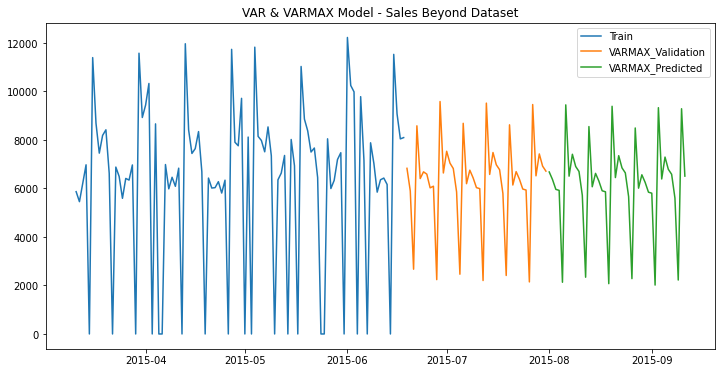

In [348]:
# Predict future values
prediction = varmax_res.forecast(steps=train.shape[0], exog=train[['Promo', 'DayOfWeek', 'Open']])

df_test_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(prediction[['Sales_li']])).rename(columns={0:'Sales'}).set_index(prediction.index)
df_test_pred_varmax = df_test_pred_varmax.loc[end_index+relativedelta(days=1):test_index]

# visualizing the data generated for the next 6 weeks BEYOND the dataset
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(df_pred_varmax['Sales'], label='VARMAX_Validation')
plt.plot(df_test_pred_varmax['Sales'], label='VARMAX_Predicted')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales Beyond Dataset')
plt.show()

<a id="store13"></a>
### Store 13 Analysis & Predictions

In [83]:
df = data[data['Store'] == 13]
df = df.asfreq('D')

Text(0.5, 1.0, 'Daily Sales')

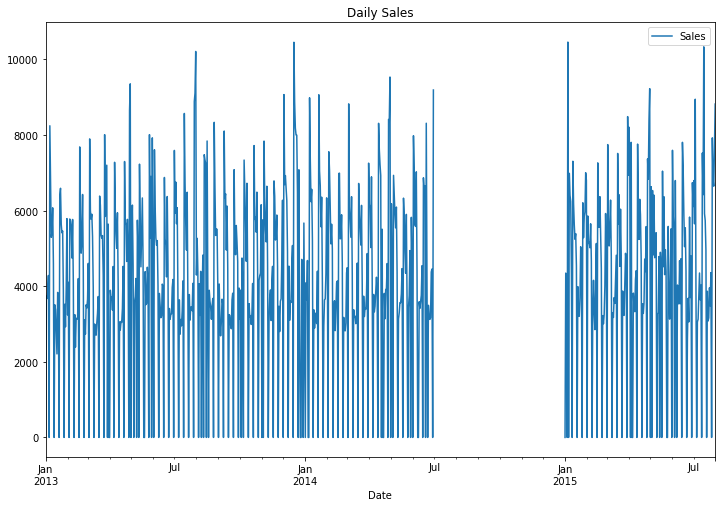

In [84]:
df['Sales'].plot(figsize=(12, 8))
plt.legend(loc='best' )
plt.title('Daily Sales')

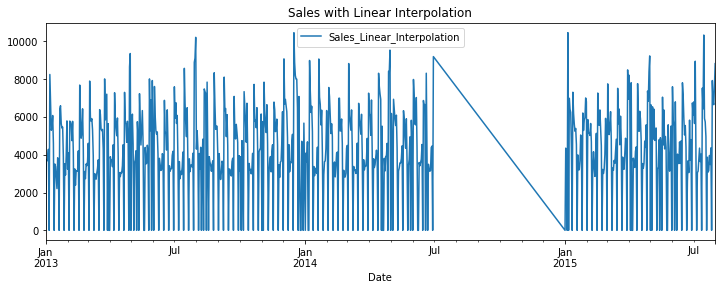

In [85]:
#trying out linear interpolation. It did not quite work
df = df.assign(Sales_Linear_Interpolation=df['Sales'].fillna(df['Sales'].interpolate(method='linear')))
df['Sales_Linear_Interpolation'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales with Linear Interpolation')
plt.show(block=False)

In [86]:
# filling up missing data with data one year ago (365 days ago)
df = df.fillna(df.shift(365))
df.loc['2014-07-01': '2014-12-31']

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales_Linear_Interpolation
Date,,,,,,,,,,,,,,,,,,
2014-07-01,13.0,1.0,7594.0,536.0,1.0,1.0,1.0,0.0,d,a,310.0,NaN,NaN,1.0,45.0,2009.0,"Feb,May,Aug,Nov",9142.313514
2014-07-02,13.0,2.0,5930.0,403.0,1.0,1.0,1.0,0.0,d,a,310.0,NaN,NaN,1.0,45.0,2009.0,"Feb,May,Aug,Nov",9092.627027
2014-07-03,13.0,3.0,6756.0,449.0,1.0,1.0,1.0,0.0,d,a,310.0,NaN,NaN,1.0,45.0,2009.0,"Feb,May,Aug,Nov",9042.940541
2014-07-04,13.0,4.0,5655.0,437.0,1.0,1.0,1.0,0.0,d,a,310.0,NaN,NaN,1.0,45.0,2009.0,"Feb,May,Aug,Nov",8993.254054
2014-07-05,13.0,5.0,6080.0,432.0,1.0,1.0,1.0,0.0,d,a,310.0,NaN,NaN,1.0,45.0,2009.0,"Feb,May,Aug,Nov",8943.567568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,13.0,5.0,4711.0,409.0,1.0,0.0,1.0,1.0,d,a,310.0,NaN,NaN,1.0,45.0,2009.0,"Feb,May,Aug,Nov",248.432432
2014-12-28,13.0,6.0,3886.0,379.0,1.0,0.0,1.0,0.0,d,a,310.0,NaN,NaN,1.0,45.0,2009.0,"Feb,May,Aug,Nov",198.745946
2014-12-29,13.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,d,a,310.0,NaN,NaN,1.0,45.0,2009.0,"Feb,May,Aug,Nov",149.059459


Text(0.5, 1.0, 'Daily Sales filled with data from last year')

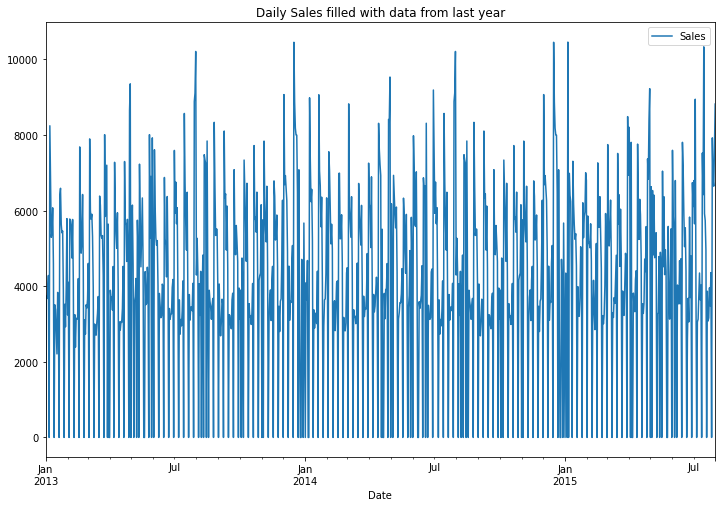

In [87]:
df['Sales'].plot(figsize=(12, 8))
plt.legend(loc='best' )
plt.title('Daily Sales filled with data from last year')

In [88]:
# removal of outliers above 99 percentile
p = np.percentile(df['Sales'], 99)

df[['Sales_li', 'Customers_li']] = df[['Sales', 'Customers']].copy()

# replace the sales and customers data for outliers point with NaN values
for col in df[['Sales_li', 'Customers_li']]:
    df[col] =  np.where(df[col] >= p, np.nan, df[col])

In [89]:
df = df.assign(Sales_li = df['Sales_li'].interpolate(method='linear')) #using interpolation to fill nan values for sales
df = df.assign(Customers_li = df['Customers_li'].interpolate(method='linear')) #using interpolation to fill nan values for customers

In [90]:
# using ADF test to check for stationarity
adf_test = adfuller(df['Sales_li'])

print("ADF Statistic for Sales: {:.2f}".format(adf_test[0]))
print("p-value for Sales: {:.2f}".format(adf_test[1]))

# using ADF test to check for stationarity
adf_test = adfuller(df['Customers_li'])

print("ADF Statistic for Customers: {:.2f}".format(adf_test[0]))
print("p-value for Customers: {:.2f}".format(adf_test[1]))

ADF Statistic for Sales: -6.94
p-value for Sales: 0.00
ADF Statistic for Customers: -6.79
p-value for Customers: 0.00


The p-value is less than .05, we reject the null hypothesis of the ADF test.
We can assume that the trend is stationary.

In [91]:
train, test = ts_train_test_split(df, period = six_weeks)
print(train.shape)
print(test.shape)

(899, 20)
(43, 20)


In [92]:
# scaling both sales and customer time series
sales_scaler = StandardScaler()
train['Sales_li'] = sales_scaler.fit_transform(train[['Sales_li']])
test['Sales_li'] = sales_scaler.fit_transform(test[['Sales_li']])

customer_scaler = StandardScaler()

train['Customers_li'] = customer_scaler.fit_transform(train[['Customers_li']])
test['Customers_li'] = customer_scaler.fit_transform(test[['Customers_li']])

In [93]:
mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(3,0), trend='n')
var_res = mod.fit(maxiter=1000, disp=False)
print(var_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Sales_li', 'Customers_li']   No. Observations:                  899
Model:                                   VAR(3)   Log Likelihood               -1322.954
Date:                          Wed, 01 Feb 2023   AIC                           2675.908
Time:                                  19:13:11   BIC                           2747.927
Sample:                              01-01-2013   HQIC                          2703.421
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):             0.02, 0.00   Jarque-Bera (JB):      32.83, 74029.14
Prob(Q):                        0.90, 1.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.29, 2.38   Skew:                      -0.06, 4.31
Prob(H) (two-sided):            0.03

In [94]:
joh_model = coint_johansen(df[['Customers_li','Sales_li']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model)

   max_eig_stat  trace_stat
0    265.646108  304.943169
1     39.297061   39.297061 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank of matrix, 2


In [95]:
# building a VAR/VARMAX model with matrix rank 2
exog = train[['Promo','Open','DayOfWeek']] 
mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(1,1), trend='n',exog=exog)
varmax_res = mod.fit(maxiter=1000, disp=False)
print(varmax_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Sales_li', 'Customers_li']   No. Observations:                  899
Model:                              VARMAX(1,1)   Log Likelihood                -667.017
Date:                          Wed, 01 Feb 2023   AIC                           1368.035
Time:                                  19:15:41   BIC                           1449.657
Sample:                              01-01-2013   HQIC                          1399.216
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):            26.86, 0.94   Jarque-Bera (JB):     56.56, 112140.56
Prob(Q):                        0.00, 0.33   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.13, 2.74   Skew:                      -0.24, 5.14
Prob(H) (two-sided):            0.29

In [96]:
# simple search to find the p for the model based on AIC value
# due to time and resources constraint, I will only be looping through p with the same three exogenous vars

p = 3

mod_list, aic_list = [], []
for i in range(1, p + 1):
    print("p : {}".format(i))
    mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(i,1), trend='n',exog=exog)
    varmax_res = mod.fit(maxiter=1000, disp=False)
    print("AIC : {}".format(varmax_res.aic))
    
    aic_list.append(varmax_res.aic)
    mod_list.append(varmax_res)
    
varmax_res = mod_list[np.argmin(aic_list)] # model with lowest AIC value

p : 1
AIC : 1368.034694417927
p : 2
AIC : 1395.1998092645908
p : 3
AIC : 1390.8470854131854


In [188]:
# building a VAR/VARMAX model with matrix rank 2
# rerunning the VARMAX model with order (2,1) as it has the lowest AIC value here and there was an issue with my graph on the previous run
exog = train[['Promo','Open','DayOfWeek']] 
mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(2,1), trend='n',exog=exog)
varmax_res = mod.fit(maxiter=1000, disp=False)
print(varmax_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Sales_li', 'Customers_li']   No. Observations:                  899
Model:                              VARMAX(2,1)   Log Likelihood                -703.557
Date:                          Wed, 01 Feb 2023   AIC                           1449.114
Time:                                  21:42:34   BIC                           1549.941
Sample:                              01-01-2013   HQIC                          1487.633
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):             1.24, 5.01   Jarque-Bera (JB):    136.69, 275473.43
Prob(Q):                        0.27, 0.03   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.32, 2.21   Skew:                      -0.36, 6.46
Prob(H) (two-sided):            0.02

In [189]:
start_index = test.index[0]
end_index = test.index[-1]
pred_var = var_res.predict(start=start_index, end=end_index)
pred_varmax = varmax_res.predict(start=start_index, end=end_index, exog= test[['Promo','Open','DayOfWeek']])

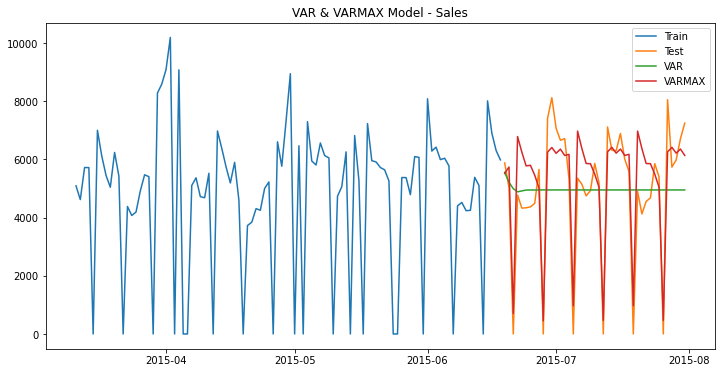

In [190]:
df_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(pred_varmax[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)
df_pred_var = pd.DataFrame(sales_scaler.inverse_transform(pred_var[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)

# visualizing the data generated for the next 6 weeks
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(df_pred_var['Sales_li'], label='VAR')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales')
plt.show()

In [191]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_var.Sales_li)).round(2)

model_comparison=pd.DataFrame()
model_comparison.loc[0,'Model']='VAR'
model_comparison.loc[0,'Variable']='Sales'
model_comparison.loc[0,'RMSE']=rmse

rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_varmax.Sales_li)).round(2)

append=pd.DataFrame()
append.loc[1,'Model']='VARMAX'
append.loc[1,'Variable']='Sales'
append.loc[1,'RMSE']=rmse

model_comparison = model_comparison.append(append)

rmse = np.sqrt(mean_squared_error(test.Customers_li, pred_varmax.Customers_li)).round(2)

append=pd.DataFrame()
append.loc[2,'Model']='VARMAX'
append.loc[2,'Variable']='Customers'
append.loc[2,'RMSE']=rmse

model_comparison = model_comparison.append(append)

# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(test.Sales_li, pred_var.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VAR'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Sales_li, pred_varmax.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Customers_li, pred_varmax.Customers_li).round(2)

model_comparison.loc[(model_comparison['Variable']=='Customers') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape
mape = "{:.2f}".format(mape)
print(model_comparison)

    Model   Variable  RMSE  MAPE
0     VAR      Sales  1.00  1.00
1  VARMAX      Sales  0.48  3.46
2  VARMAX  Customers  0.51   3.2


RMSE and MAPE for the VARMAX on Sales as above. AIC and BIC values could be much lower for a better fit model which can also produce lower RMSE values.

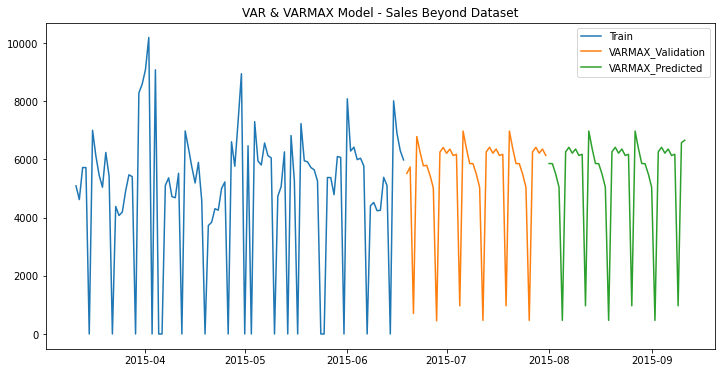

In [192]:
# Predict future values
prediction = varmax_res.forecast(steps=train.shape[0], exog=train[['Promo','Open','DayOfWeek']])

df_test_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(prediction[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(prediction.index)
df_test_pred_varmax = df_test_pred_varmax.loc[end_index+relativedelta(days=1):test_index]

# visualizing the data generated for the next 6 weeks BEYOND the dataset
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX_Validation')
plt.plot(df_test_pred_varmax['Sales_li'], label='VARMAX_Predicted')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales Beyond Dataset')
plt.show()

<a id="store25"></a>
### Store 25 Analysis & Predictions

In [101]:
df = data[data['Store'] == 25]
df = df.asfreq('D')

In [102]:
# removal of outliers above 99 percentile
p = np.percentile(df['Sales'], 99)

df[['Sales_li', 'Customers_li']] = df[['Sales', 'Customers']].copy()

# replace the sales and customers data for outliers point with NaN values
for col in df[['Sales_li', 'Customers_li']]:
    df[col] =  np.where(df[col] >= p, np.nan, df[col])

df = df.assign(Sales_li = df['Sales_li'].interpolate(method='linear')) #using interpolation to fill nan values for sales
df = df.assign(Customers_li = df['Customers_li'].interpolate(method='linear')) #using interpolation to fill nan values for customers

In [103]:
# using ADF test to check for stationarity
adf_test = adfuller(df['Sales_li'])

print("ADF Statistic for Sales: {:.2f}".format(adf_test[0]))
print("p-value for Sales: {:.2f}".format(adf_test[1]))

# using ADF test to check for stationarity
adf_test = adfuller(df['Customers_li'])

print("ADF Statistic for Customers: {:.2f}".format(adf_test[0]))
print("p-value for Customers: {:.2f}".format(adf_test[1]))

ADF Statistic for Sales: -4.14
p-value for Sales: 0.00
ADF Statistic for Customers: -4.04
p-value for Customers: 0.00


The p-value is less than .05, we reject the null hypothesis of the ADF test. We can assume that the trend is stationary.

In [104]:
train, test = ts_train_test_split(df, period = six_weeks)
print(train.shape)
print(test.shape)

(899, 19)
(43, 19)


In [105]:
# scaling both sales and customer data
sales_scaler = StandardScaler()
train['Sales_li'] = sales_scaler.fit_transform(train[['Sales_li']])
test['Sales_li'] = sales_scaler.fit_transform(test[['Sales_li']])

customer_scaler = StandardScaler()

train['Customers_li'] = customer_scaler.fit_transform(train[['Customers_li']])
test['Customers_li'] = customer_scaler.fit_transform(test[['Customers_li']])

In [106]:
mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(3,0), trend='n')
var_res = mod.fit(maxiter=1000, disp=False)
print(var_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Sales_li', 'Customers_li']   No. Observations:                  899
Model:                                   VAR(3)   Log Likelihood               -1352.145
Date:                          Wed, 01 Feb 2023   AIC                           2734.291
Time:                                  19:32:24   BIC                           2806.310
Sample:                              01-01-2013   HQIC                          2761.804
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):             0.00, 0.18   Jarque-Bera (JB):     71.89, 142924.52
Prob(Q):                        0.99, 0.67   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.99, 0.13   Skew:                      -0.66, 5.87
Prob(H) (two-sided):            0.91

In [107]:
joh_model = coint_johansen(df[['Customers_li','Sales_li']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model)

   max_eig_stat  trace_stat
0    243.624467  287.131352
1     43.506885   43.506885 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank of matrix, 2


In [108]:
# okay to build VAR/VARMAX models with matrix rank of 2
exog = train[['Promo','Open','DayOfWeek']] 
mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(1,1), trend='n',exog=exog)
varmax_res = mod.fit(maxiter=1000, disp=False)
print(varmax_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Sales_li', 'Customers_li']   No. Observations:                  899
Model:                              VARMAX(1,1)   Log Likelihood                -599.577
Date:                          Wed, 01 Feb 2023   AIC                           1233.153
Time:                                  19:35:18   BIC                           1314.775
Sample:                              01-01-2013   HQIC                          1264.335
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):           32.92, 25.26   Jarque-Bera (JB):   1409.14, 158701.38
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.62, 0.21   Skew:                      -1.02, 6.53
Prob(H) (two-sided):            0.00

In [109]:
# simple search to find the p for the model based on AIC value
# due to time and resources constraint, I will only be looping through p with the same three exogenous vars

p = 3

mod_list, aic_list = [], []
for i in range(1, p + 1):
    print("p : {}".format(i))
    mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(i,1), trend='n',exog=exog)
    varmax_res = mod.fit(maxiter=1000, disp=False)
    print("AIC : {}".format(varmax_res.aic))
    
    aic_list.append(varmax_res.aic)
    mod_list.append(varmax_res)
    
varmax_res = mod_list[np.argmin(aic_list)] # model with lowest AIC value

p : 1
AIC : 1233.153309413261
p : 2
AIC : 1105.9697450354906
p : 3
AIC : 1167.2104206154672


In [110]:
start_index = test.index[0]
end_index = test.index[-1]
pred_var = var_res.predict(start=start_index, end=end_index)
pred_varmax = varmax_res.predict(start=start_index, end=end_index, exog= test[['Promo','Open','DayOfWeek']])

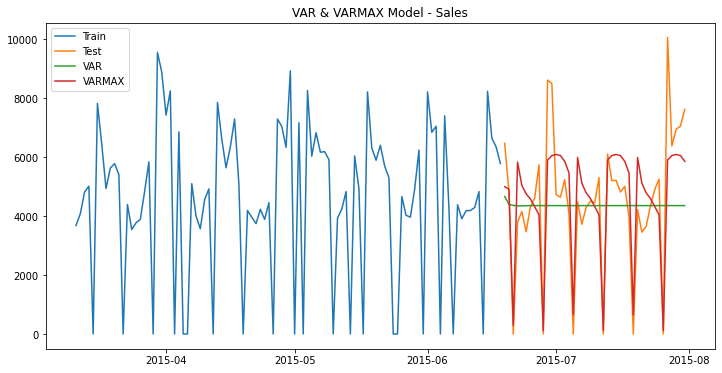

In [159]:
df_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(pred_varmax[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)
df_pred_var = pd.DataFrame(sales_scaler.inverse_transform(pred_var[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)

# visualizing the data generated for the next 6 weeks
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(df_pred_var['Sales_li'], label='VAR')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales')
plt.show()

In [115]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_var.Sales_li)).round(2)

model_comparison=pd.DataFrame()
model_comparison.loc[0,'Model']='VAR'
model_comparison.loc[0,'Variable']='Sales'
model_comparison.loc[0,'RMSE']=rmse

rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_varmax.Sales_li)).round(2)

append=pd.DataFrame()
append.loc[1,'Model']='VARMAX'
append.loc[1,'Variable']='Sales'
append.loc[1,'RMSE']=rmse

model_comparison = model_comparison.append(append)

rmse = np.sqrt(mean_squared_error(test.Customers_li, pred_varmax.Customers_li)).round(2)

append=pd.DataFrame()
append.loc[2,'Model']='VARMAX'
append.loc[2,'Variable']='Customers'
append.loc[2,'RMSE']=rmse

model_comparison = model_comparison.append(append)

# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(test.Sales_li, pred_var.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VAR'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Sales_li, pred_varmax.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Customers_li, pred_varmax.Customers_li).round(2)

model_comparison.loc[(model_comparison['Variable']=='Customers') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape
mape = "{:.2f}".format(mape)
print(model_comparison)

    Model   Variable  RMSE  MAPE
0     VAR      Sales  1.00  0.99
1  VARMAX      Sales  0.38  2.24
2  VARMAX  Customers  0.35  1.35


RMSE and MAPE for the VARMAX on Sales as above. AIC and BIC values could be much lower for a better fit model which can also produce lower RMSE values.

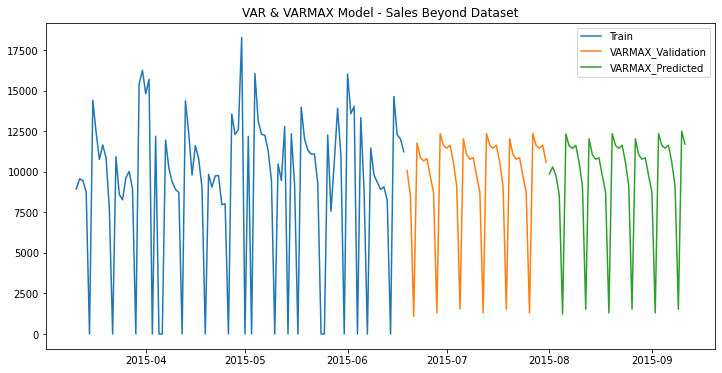

In [116]:
# Predict future values
prediction = varmax_res.forecast(steps=train.shape[0], exog=train[['Promo','Open','DayOfWeek']])

df_test_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(prediction[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(prediction.index)
df_test_pred_varmax = df_test_pred_varmax.loc[end_index+relativedelta(days=1):test_index]

# visualizing the data generated for the next 6 weeks BEYOND the dataset
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX_Validation')
plt.plot(df_test_pred_varmax['Sales_li'], label='VARMAX_Predicted')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales Beyond Dataset')
plt.show()

<a id="store29"></a>
### Store 29 Analysis & Predictions

In [117]:
df= data[data['Store'] == 29]
df = df.asfreq('D')

In [118]:
# removal of outliers above 99 percentile
p = np.percentile(df['Sales'], 99)

df[['Sales_li', 'Customers_li']] = df[['Sales', 'Customers']].copy()

# replace the sales and customers data for outliers point with NaN values
for col in df[['Sales_li', 'Customers_li']]:
    df[col] =  np.where(df[col] >= p, np.nan, df[col])

df = df.assign(Sales_li = df['Sales_li'].interpolate(method='linear')) #using interpolation to fill nan values for sales
df = df.assign(Customers_li = df['Customers_li'].interpolate(method='linear')) #using interpolation to fill nan values for customers

In [119]:
# using ADF test to check for stationarity
adf_test = adfuller(df['Sales_li'])

print("ADF Statistic for Sales: {:.2f}".format(adf_test[0]))
print("p-value for Sales: {:.2f}".format(adf_test[1]))

# using ADF test to check for stationarity
adf_test = adfuller(df['Customers_li'])

print("ADF Statistic for Customers: {:.2f}".format(adf_test[0]))
print("p-value for Customers: {:.2f}".format(adf_test[1]))

ADF Statistic for Sales: -3.39
p-value for Sales: 0.01
ADF Statistic for Customers: -3.27
p-value for Customers: 0.02


The p-value is less than .05, we reject the null hypothesis of the ADF test. We can assume that the trend is stationary.

In [120]:
train, test = ts_train_test_split(df, period = six_weeks)
print(train.shape)
print(test.shape)

(899, 19)
(43, 19)


In [121]:
# scaling both the sales and customers data
sales_scaler = StandardScaler()
train['Sales_li'] = sales_scaler.fit_transform(train[['Sales_li']])
test['Sales_li'] = sales_scaler.fit_transform(test[['Sales_li']])

customer_scaler = StandardScaler()

train['Customers_li'] = customer_scaler.fit_transform(train[['Customers_li']])
test['Customers_li'] = customer_scaler.fit_transform(test[['Customers_li']])

In [122]:
mod = sm.tsa.VARMAX(train[['Customers_li','Sales_li']].astype('float32'), order=(3,0), trend='n')
var_res = mod.fit(maxiter=1000, disp=False)
print(var_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Customers_li', 'Sales_li']   No. Observations:                  899
Model:                                   VAR(3)   Log Likelihood               -1335.106
Date:                          Wed, 01 Feb 2023   AIC                           2700.213
Time:                                  19:57:46   BIC                           2772.232
Sample:                              01-01-2013   HQIC                          2727.726
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):             0.00, 0.00   Jarque-Bera (JB):      82.54, 29364.22
Prob(Q):                        0.97, 0.95   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.72, 4.50   Skew:                     -0.74, -3.35
Prob(H) (two-sided):            0.00

In [123]:
joh_model = coint_johansen(df[['Customers','Sales']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model)

   max_eig_stat  trace_stat
0    162.006246  194.269821
1     32.263575   32.263575 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank of matrix, 2


In [124]:
# running VAR/VARMAX model due to rank of matrix being 2
exog = train[['Promo','Open','DayOfWeek']]
mod = sm.tsa.VARMAX(train[['Customers_li','Sales_li']].astype('float32'), order=(1,1), trend='n',exog=exog)
varmax_res = mod.fit(maxiter=1000, disp=False)
print(varmax_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Customers_li', 'Sales_li']   No. Observations:                  899
Model:                              VARMAX(1,1)   Log Likelihood                -654.790
Date:                          Wed, 01 Feb 2023   AIC                           1343.581
Time:                                  20:00:19   BIC                           1425.203
Sample:                              01-01-2013   HQIC                          1374.763
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):             1.85, 1.24   Jarque-Bera (JB):     104.29, 51957.64
Prob(Q):                        0.17, 0.26   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.07, 5.07   Skew:                     -0.48, -4.53
Prob(H) (two-sided):            0.54

In [125]:
# simple search to find the p for the model based on AIC value
# due to time and resources constraint, I will only be looping through p with the same three exogenous vars

p = 3

mod_list, aic_list = [], []
for i in range(1, p + 1):
    print("p : {}".format(i))
    mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(i,1), trend='n',exog=exog)
    varmax_res = mod.fit(maxiter=1000, disp=False)
    print("AIC : {}".format(varmax_res.aic))
    
    aic_list.append(varmax_res.aic)
    mod_list.append(varmax_res)
    
varmax_res = mod_list[np.argmin(aic_list)] # model with lowest AIC value

p : 1
AIC : 1276.8080110786254
p : 2
AIC : 1238.5978973156125
p : 3
AIC : 1331.7340823068466


In [126]:
start_index = test.index[0]
end_index = test.index[-1]
pred_var = var_res.predict(start=start_index, end=end_index)
pred_varmax = varmax_res.predict(start=start_index, end=end_index, exog= test[['Promo','Open','DayOfWeek']] )

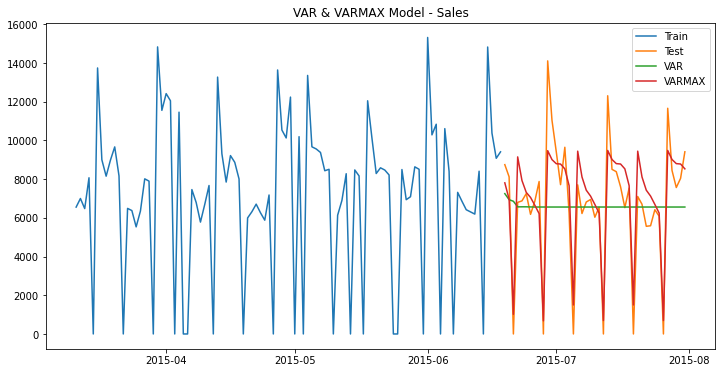

In [127]:
df_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(pred_varmax[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)
df_pred_var = pd.DataFrame(sales_scaler.inverse_transform(pred_var[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)

# visualizing the data generated for the next 6 weeks
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(df_pred_var['Sales_li'], label='VAR')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales')
plt.show()

In [128]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_var.Sales_li)).round(2)

model_comparison=pd.DataFrame()
model_comparison.loc[0,'Model']='VAR'
model_comparison.loc[0,'Variable']='Sales'
model_comparison.loc[0,'RMSE']=rmse

rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_varmax.Sales_li)).round(2)

append=pd.DataFrame()
append.loc[1,'Model']='VARMAX'
append.loc[1,'Variable']='Sales'
append.loc[1,'RMSE']=rmse

model_comparison = model_comparison.append(append)

rmse = np.sqrt(mean_squared_error(test.Customers_li, pred_varmax.Customers_li)).round(2)

append=pd.DataFrame()
append.loc[2,'Model']='VARMAX'
append.loc[2,'Variable']='Customers'
append.loc[2,'RMSE']=rmse

model_comparison = model_comparison.append(append)

# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(test.Sales_li, pred_var.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VAR'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Sales_li, pred_varmax.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Customers_li, pred_varmax.Customers_li).round(2)

model_comparison.loc[(model_comparison['Variable']=='Customers') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape
mape = "{:.2f}".format(mape)
print(model_comparison)

    Model   Variable  RMSE  MAPE
0     VAR      Sales  1.00  0.99
1  VARMAX      Sales  0.47  3.64
2  VARMAX  Customers  0.45  1.96


RMSE and MAPE for the VARMAX on Sales as above. AIC and BIC values could be much lower for a better fit model which can also produce lower RMSE values.

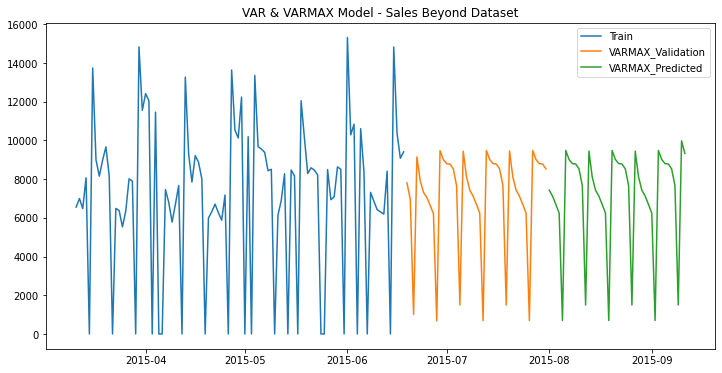

In [129]:
# Predict future values
prediction = varmax_res.forecast(steps=train.shape[0], exog=train[['Promo','Open','DayOfWeek']])

df_test_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(prediction[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(prediction.index)
df_test_pred_varmax = df_test_pred_varmax.loc[end_index+relativedelta(days=1):test_index]

# visualizing the data generated for the next 6 weeks BEYOND the dataset
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX_Validation')
plt.plot(df_test_pred_varmax['Sales_li'], label='VARMAX_Predicted')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales Beyond Dataset')
plt.show()

<a id="store31"></a>
### Store 31 Analysis & Predictions

In [235]:
df = data[data['Store'] == 31]
df = df.asfreq('D')

In [236]:
# removal of outliers above 99 percentile
p = np.percentile(df['Sales'], 99)

df[['Sales_li', 'Customers_li']] = df[['Sales', 'Customers']].copy()

# replace the sales and customers data for outliers point with NaN values
for col in df[['Sales_li', 'Customers_li']]:
    df[col] =  np.where(df[col] >= p, np.nan, df[col])

df = df.assign(Sales_li = df['Sales_li'].interpolate(method='linear')) #using interpolation to fill nan values for sales
df = df.assign(Customers_li = df['Customers_li'].interpolate(method='linear')) #using interpolation to fill nan values for customers

In [237]:
# using ADF test to check for stationarity
adf_test = adfuller(df['Sales_li'])

print("ADF Statistic for Sales: {:.2f}".format(adf_test[0]))
print("p-value for Sales: {:.2f}".format(adf_test[1]))

# using ADF test to check for stationarity
adf_test = adfuller(df['Customers_li'])

print("ADF Statistic for Customers: {:.2f}".format(adf_test[0]))
print("p-value for Customers: {:.2f}".format(adf_test[1]))

ADF Statistic for Sales: -6.03
p-value for Sales: 0.00
ADF Statistic for Customers: -5.15
p-value for Customers: 0.00


The p-value is less than .05, we reject the null hypothesis of the ADF test.
We can assume that the trend is stationary.

Text(0.5, 1.0, 'Daily Sales filled with data from last year')

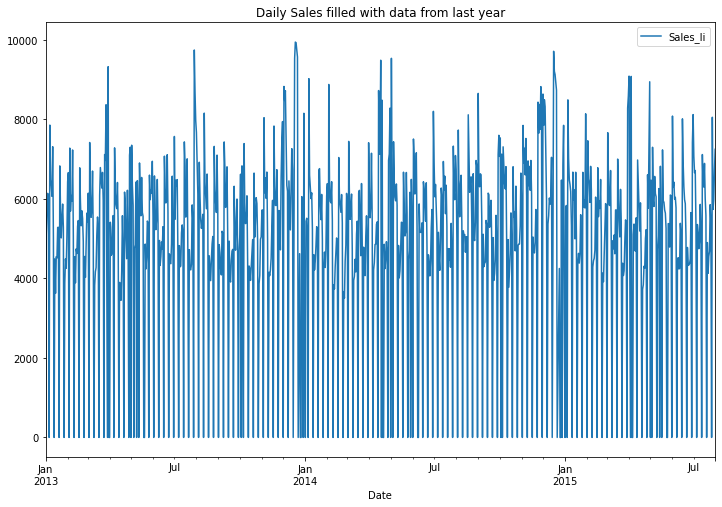

In [239]:
df['Sales_li'].plot(figsize=(12, 8))
plt.legend(loc='best' )
plt.title('Daily Sales filled with data from last year')

In [240]:
train, test = ts_train_test_split(df, period = six_weeks)
print(train.shape)
print(test.shape)

(899, 19)
(43, 19)


In [241]:
# scaling both sales and customer data

sales_scaler = StandardScaler()
train['Sales_li'] = sales_scaler.fit_transform(train[['Sales_li']])
test['Sales_li'] = sales_scaler.fit_transform(test[['Sales_li']])

customer_scaler = StandardScaler()

train['Customers_li'] = customer_scaler.fit_transform(train[['Customers_li']])
test['Customers_li'] = customer_scaler.fit_transform(test[['Customers_li']])

In [243]:
mod = sm.tsa.VARMAX(train[['Customers_li','Sales_li']].astype('float32'), order=(1,0), trend='n')
var_res = mod.fit(maxiter=1000, disp=False)
print(var_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Customers_li', 'Sales_li']   No. Observations:                  899
Model:                                   VAR(1)   Log Likelihood               -1450.004
Date:                          Wed, 01 Feb 2023   AIC                           2914.008
Time:                                  22:19:02   BIC                           2947.617
Sample:                              01-01-2013   HQIC                          2926.848
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):             1.62, 0.18   Jarque-Bera (JB):    202.14, 160653.28
Prob(Q):                        0.20, 0.67   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.20, 2.42   Skew:                     -0.99, -5.10
Prob(H) (two-sided):            0.11

In [244]:
joh_model = coint_johansen(df[['Customers','Sales']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model)

   max_eig_stat  trace_stat
0    125.379475  158.802368
1     33.422893   33.422893 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank of matrix, 2


In [167]:
# running VAR/VARMAX model due to rank of matrix being 2
exog = train[['Promo', 'DayOfWeek', 'Open']]
mod = sm.tsa.VARMAX(train[['Customers_li','Sales_li']].astype('float32'), order=(1,1), trend='n',exog=exog)
varmax_res = mod.fit(maxiter=1000, disp=False)
print(varmax_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Customers_li', 'Sales_li']   No. Observations:                  899
Model:                              VARMAX(1,1)   Log Likelihood                -768.036
Date:                          Wed, 01 Feb 2023   AIC                           1570.072
Time:                                  21:11:17   BIC                           1651.694
Sample:                              01-01-2013   HQIC                          1601.254
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):            0.04, 16.86   Jarque-Bera (JB):    171.79, 228243.75
Prob(Q):                        0.83, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.96, 3.07   Skew:                      0.00, -6.57
Prob(H) (two-sided):            0.70

In [168]:
# simple search to find the p for the model based on AIC value
# due to time and resources constraint, I will only be looping through p with the same three exogenous vars

p = 3

mod_list, aic_list = [], []
for i in range(1, p + 1):
    print("p : {}".format(i))
    mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(i,1), trend='n',exog=exog)
    varmax_res = mod.fit(maxiter=1000, disp=False)
    print("AIC : {}".format(varmax_res.aic))
    
    aic_list.append(varmax_res.aic)
    mod_list.append(varmax_res)
    
varmax_res = mod_list[np.argmin(aic_list)] # model with lowest AIC value

p : 1
AIC : 1570.0573552131148
p : 2
AIC : 1427.4382220319867
p : 3
AIC : 1473.0335128058266


In [249]:
# building a VAR/VARMAX model with matrix rank 2
# rerunning the VARMAX model with order (2,1) as it has the lowest AIC value here and there was an issue with my graph on the previous run
exog = train[['Promo','Open','DayOfWeek']] 
mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']], order=(2,1), trend='n',exog=exog)
varmax_res = mod.fit(maxiter=1000, disp=False)
print(varmax_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Sales_li', 'Customers_li']   No. Observations:                  899
Model:                              VARMAX(2,1)   Log Likelihood                -677.643
Date:                          Wed, 01 Feb 2023   AIC                           1397.286
Time:                                  22:30:38   BIC                           1498.113
Sample:                              01-01-2013   HQIC                          1435.804
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):            1.35, 11.34   Jarque-Bera (JB):    189.73, 130224.00
Prob(Q):                        0.25, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.39, 1.78   Skew:                      -0.17, 4.02
Prob(H) (two-sided):            0.00

In [250]:
start_index = test.index[0]
end_index = test.index[-1]
pred_var = var_res.predict(start=start_index, end=end_index)
pred_varmax = varmax_res.predict(start=start_index, end=end_index, exog= test[['Promo', 'DayOfWeek', 'Open']])

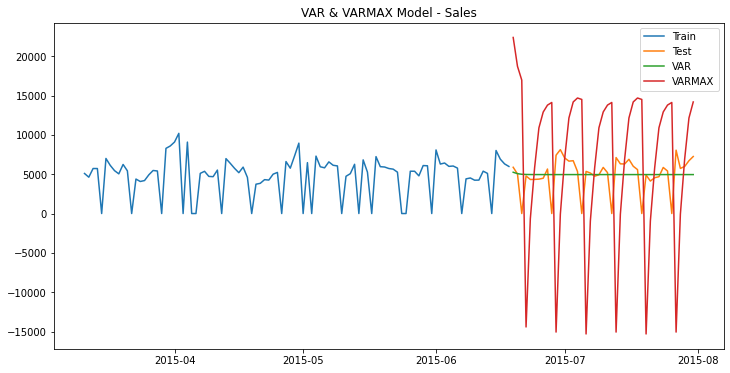

In [251]:
df_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(pred_varmax[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)
df_pred_var = pd.DataFrame(sales_scaler.inverse_transform(pred_var[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)

# visualizing the data generated for the next 6 weeks
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(df_pred_var['Sales_li'], label='VAR')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales')
plt.show()

In [257]:
# building a VAR/VARMAX model with matrix rank 2
# rerunning the VARMAX model with order (1,1) as despite the low AIC value
# because I am quite dissatisfied with the above output
exog = train[['Promo','Open','DayOfWeek']] 
mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']], order=(1,1), trend='n',exog=exog)
varmax_res = mod.fit(maxiter=1000, disp=False)
print(varmax_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Sales_li', 'Customers_li']   No. Observations:                  899
Model:                              VARMAX(1,1)   Log Likelihood                -768.029
Date:                          Wed, 01 Feb 2023   AIC                           1570.058
Time:                                  22:41:11   BIC                           1651.680
Sample:                              01-01-2013   HQIC                          1601.240
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):            0.02, 17.00   Jarque-Bera (JB):     96.85, 276333.51
Prob(Q):                        0.90, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.12, 2.45   Skew:                      -0.19, 7.24
Prob(H) (two-sided):            0.33

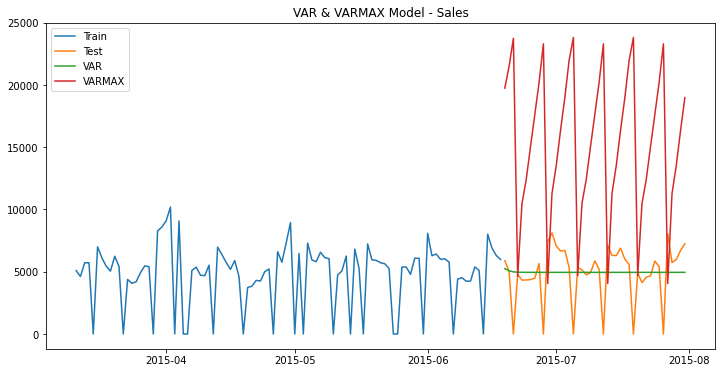

In [258]:
pred_varmax = varmax_res.predict(start=start_index, end=end_index, exog= test[['Promo', 'DayOfWeek', 'Open']])
df_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(pred_varmax[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)

# visualizing the data generated for the next 6 weeks
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(df_pred_var['Sales_li'], label='VAR')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales')
plt.show()

In [259]:
# building a VAR/VARMAX model with matrix rank 2
# rerunning the VARMAX model with order (1,1) as despite the low AIC value
# because I am quite dissatisfied with the above output and I am going for a more parsimonious approach
# with just one exogenous variable
exog = train[['Promo']]
mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']], order=(1,1), trend='n',exog=exog)
varmax_res = mod.fit(maxiter=1000, disp=False)
print(varmax_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Sales_li', 'Customers_li']   No. Observations:                  899
Model:                              VARMAX(1,1)   Log Likelihood               -1299.630
Date:                          Wed, 01 Feb 2023   AIC                           2625.259
Time:                                  22:45:04   BIC                           2687.676
Sample:                              01-01-2013   HQIC                          2649.104
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):            3.11, 19.98   Jarque-Bera (JB):    112.26, 212087.37
Prob(Q):                        0.08, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.23, 2.29   Skew:                      -0.71, 6.46
Prob(H) (two-sided):            0.07

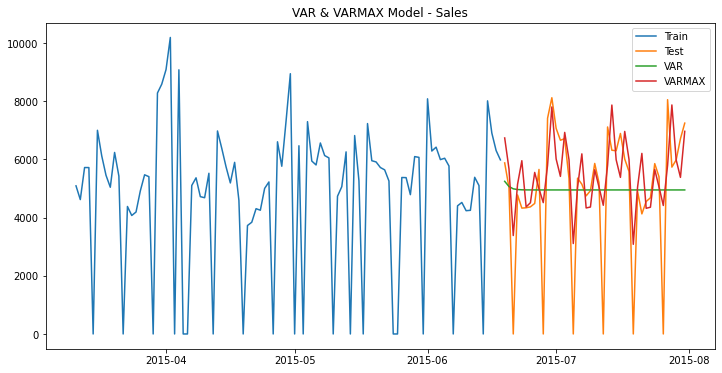

In [260]:
pred_varmax = varmax_res.predict(start=start_index, end=end_index, exog= test[['Promo']])
df_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(pred_varmax[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)

# visualizing the data generated for the next 6 weeks
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(df_pred_var['Sales_li'], label='VAR')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales')
plt.show()

In [261]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_var.Sales_li)).round(2)

model_comparison=pd.DataFrame()
model_comparison.loc[0,'Model']='VAR'
model_comparison.loc[0,'Variable']='Sales'
model_comparison.loc[0,'RMSE']=rmse

rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_varmax.Sales_li)).round(2)

append=pd.DataFrame()
append.loc[1,'Model']='VARMAX'
append.loc[1,'Variable']='Sales'
append.loc[1,'RMSE']=rmse

model_comparison = model_comparison.append(append)

rmse = np.sqrt(mean_squared_error(test.Customers_li, pred_varmax.Customers_li)).round(2)

append=pd.DataFrame()
append.loc[2,'Model']='VARMAX'
append.loc[2,'Variable']='Customers'
append.loc[2,'RMSE']=rmse

model_comparison = model_comparison.append(append)

# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(test.Sales_li, pred_var.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VAR'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Sales_li, pred_varmax.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Customers_li, pred_varmax.Customers_li).round(2)

model_comparison.loc[(model_comparison['Variable']=='Customers') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape
mape = "{:.2f}".format(mape)
print(model_comparison)

    Model   Variable  RMSE  MAPE
0     VAR      Sales  1.00  0.98
1  VARMAX      Sales  0.77  1.74
2  VARMAX  Customers  0.82  1.49


RMSE and MAPE for the VARMAX on Sales as above. AIC and BIC values could be much lower for a better fit model which can also produce lower RMSE values. This model will require more experimentation in terms of finding optimal p and q to produce a better model.

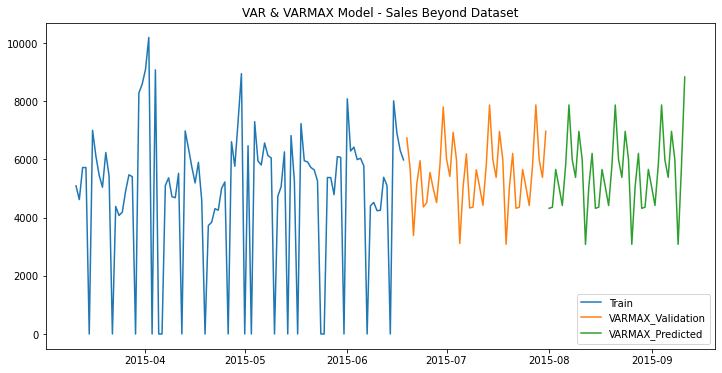

In [263]:
# Predict future values
prediction = varmax_res.forecast(steps=train.shape[0], exog=train[['Promo']])

df_test_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(prediction[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(prediction.index)
df_test_pred_varmax = df_test_pred_varmax.loc[end_index+relativedelta(days=1):test_index]

# visualizing the data generated for the next 6 weeks BEYOND the dataset
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX_Validation')
plt.plot(df_test_pred_varmax['Sales_li'], label='VARMAX_Predicted')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales Beyond Dataset')
plt.show()

<a id="store46"></a>
### Store 46 Analysis & Predictions

In [143]:
df = data[data['Store'] == 46]
df = df.asfreq('D')

Text(0.5, 1.0, 'Daily Sales')

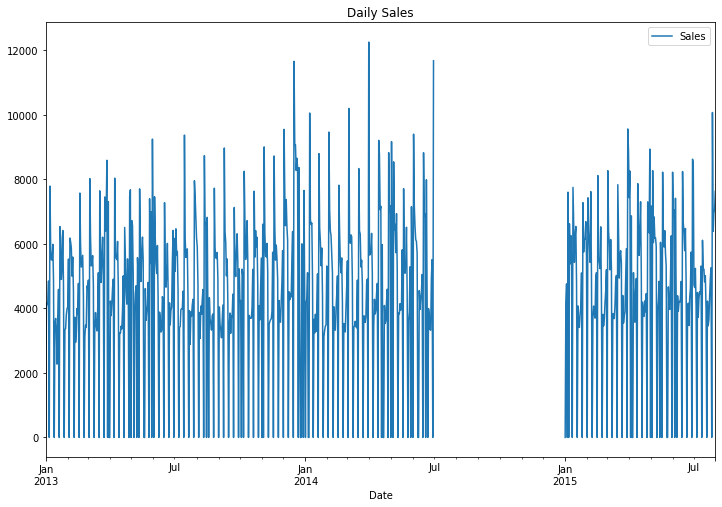

In [144]:
df['Sales'].plot(figsize=(12, 8))
plt.legend(loc='best' )
plt.title('Daily Sales')

In [145]:
df = df.fillna(df.shift(365)) #filling na data with last year's data
df.loc['2014-07-01': '2014-12-31'] 

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,
2014-07-01,46.0,1.0,6167.0,717.0,1.0,1.0,1.0,0.0,c,a,1200.0,9.0,2005.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
2014-07-02,46.0,2.0,5146.0,625.0,1.0,1.0,1.0,0.0,c,a,1200.0,9.0,2005.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
2014-07-03,46.0,3.0,6463.0,683.0,1.0,1.0,1.0,0.0,c,a,1200.0,9.0,2005.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
2014-07-04,46.0,4.0,5652.0,684.0,1.0,1.0,1.0,0.0,c,a,1200.0,9.0,2005.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
2014-07-05,46.0,5.0,5767.0,713.0,1.0,1.0,1.0,0.0,c,a,1200.0,9.0,2005.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,46.0,5.0,5999.0,761.0,1.0,0.0,1.0,1.0,c,a,1200.0,9.0,2005.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
2014-12-28,46.0,6.0,5814.0,738.0,1.0,0.0,1.0,0.0,c,a,1200.0,9.0,2005.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
2014-12-29,46.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,c,a,1200.0,9.0,2005.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"


Text(0.5, 1.0, 'Daily Sales')

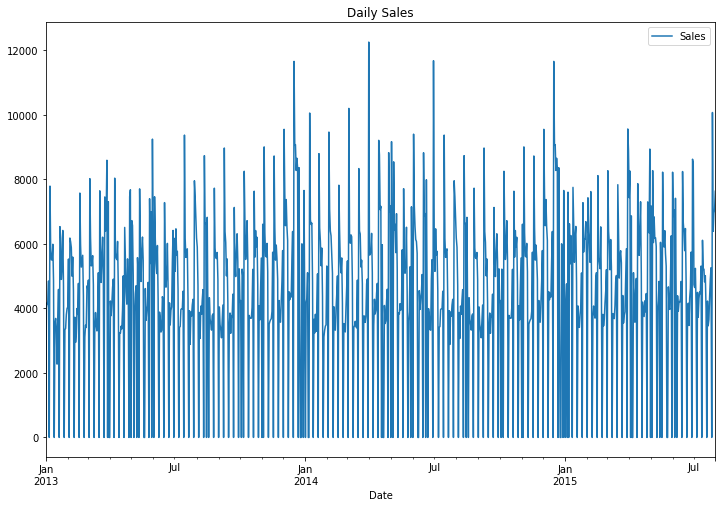

In [146]:
df['Sales'].plot(figsize=(12, 8)) 
plt.legend(loc='best' )
plt.title('Daily Sales')

In [147]:
# removal of outliers above 99 percentile
p = np.percentile(df['Sales'], 99)

df[['Sales_li', 'Customers_li']] = df[['Sales', 'Customers']].copy()

# replace the sales and customers data for outliers point with NaN values
for col in df[['Sales_li', 'Customers_li']]:
    df[col] =  np.where(df[col] >= p, np.nan, df[col])

df = df.assign(Sales_li = df['Sales_li'].interpolate(method='linear')) #using interpolation to fill nan values for sales
df = df.assign(Customers_li = df['Customers_li'].interpolate(method='linear')) #using interpolation to fill nan values for customers

In [148]:
# using ADF test to check for stationarity
adf_test = adfuller(df['Sales_li'])

print("ADF Statistic for Sales: {:.2f}".format(adf_test[0]))
print("p-value for Sales: {:.2f}".format(adf_test[1]))

# using ADF test to check for stationarity
adf_test = adfuller(df['Customers_li'])

print("ADF Statistic for Customers: {:.2f}".format(adf_test[0]))
print("p-value for Customers: {:.2f}".format(adf_test[1]))

ADF Statistic for Sales: -6.83
p-value for Sales: 0.00
ADF Statistic for Customers: -6.32
p-value for Customers: 0.00


The p-value is less than .05, we reject the null hypothesis of the ADF test. We can assume that the trend is stationary.

In [149]:
train, test = ts_train_test_split(df, period = six_weeks)
print(train.shape)
print(test.shape)

(899, 19)
(43, 19)


In [150]:
# scaling both sales and customer data
sales_scaler = StandardScaler()
train['Sales_li'] = sales_scaler.fit_transform(train[['Sales_li']])
test['Sales_li'] = sales_scaler.fit_transform(test[['Sales_li']])

customer_scaler = StandardScaler()

train['Customers_li'] = customer_scaler.fit_transform(train[['Customers_li']])
test['Customers_li'] = customer_scaler.fit_transform(test[['Customers_li']])

In [151]:
mod = sm.tsa.VARMAX(train[['Customers_li','Sales_li']].astype('float32'), order=(3,0), trend='n')
var_res = mod.fit(maxiter=1000, disp=False)
print(var_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Customers_li', 'Sales_li']   No. Observations:                  899
Model:                                   VAR(3)   Log Likelihood               -1370.390
Date:                          Wed, 01 Feb 2023   AIC                           2770.779
Time:                                  20:39:23   BIC                           2842.798
Sample:                              01-01-2013   HQIC                          2798.293
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):             0.00, 0.00   Jarque-Bera (JB):       53.26, 9658.20
Prob(Q):                        0.99, 0.97   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.31, 1.84   Skew:                     -0.55, -1.66
Prob(H) (two-sided):            0.02

In [152]:
joh_model = coint_johansen(df[['Customers','Sales']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model)

   max_eig_stat  trace_stat
0    167.181755  198.004214
1     30.822460   30.822460 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank of matrix, 2


In [153]:
# running VAR/VARMAX model due to rank of matrix being 2
exog = train[['Promo','Open','DayOfWeek']] 
mod = sm.tsa.VARMAX(train[['Customers_li','Sales_li']].astype('float32'), order=(1,1), trend='n',exog=exog)
varmax_res = mod.fit(maxiter=1000, disp=False)
print(varmax_res.summary())

                                Statespace Model Results                                
Dep. Variable:     ['Customers_li', 'Sales_li']   No. Observations:                  899
Model:                              VARMAX(1,1)   Log Likelihood                -661.917
Date:                          Wed, 01 Feb 2023   AIC                           1357.834
Time:                                  20:43:17   BIC                           1439.456
Sample:                              01-01-2013   HQIC                          1389.016
                                   - 06-18-2015                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):            3.60, 16.03   Jarque-Bera (JB):       4.07, 12259.43
Prob(Q):                        0.06, 0.00   Prob(JB):                   0.13, 0.00
Heteroskedasticity (H):         1.01, 2.03   Skew:                     -0.08, -2.29
Prob(H) (two-sided):            0.91

In [154]:
# simple search to find the p for the model based on AIC value
# due to time and resources constraint, I will only be looping through p with the same three exogenous vars

p = 3

mod_list, aic_list = [], []
for i in range(1, p + 1):
    print("p : {}".format(i))
    mod = sm.tsa.VARMAX(train[['Sales_li','Customers_li']].astype('float32'), order=(i,1), trend='n',exog=exog)
    varmax_res = mod.fit(maxiter=1000, disp=False)
    print("AIC : {}".format(varmax_res.aic))
    
    aic_list.append(varmax_res.aic)
    mod_list.append(varmax_res)
    
varmax_res = mod_list[np.argmin(aic_list)] # model with lowest AIC value

p : 1
AIC : 1368.3204075402678
p : 2
AIC : 1226.4293759979946
p : 3
AIC : 1336.5210238213112


In [155]:
start_index = test.index[0]
end_index = test.index[-1]
pred_var = var_res.predict(start=start_index, end=end_index)
pred_varmax = varmax_res.predict(start=start_index, end=end_index, exog= test[['Promo','Open','DayOfWeek']] )

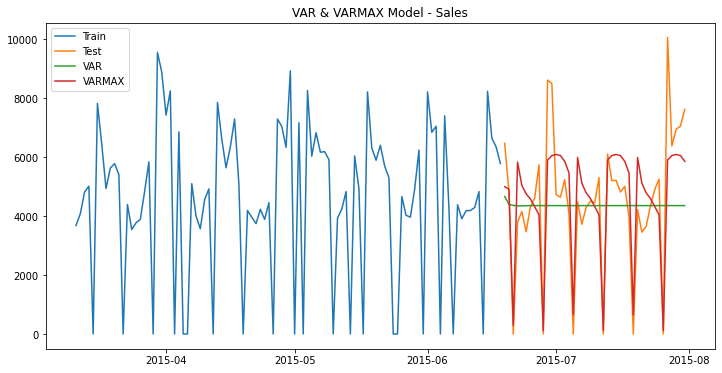

In [156]:
df_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(pred_varmax[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)
df_pred_var = pd.DataFrame(sales_scaler.inverse_transform(pred_var[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(test.index)

# visualizing the data generated for the next 6 weeks
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(df_pred_var['Sales_li'], label='VAR')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales')
plt.show()

In [157]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_var.Sales_li)).round(2)

model_comparison=pd.DataFrame()
model_comparison.loc[0,'Model']='VAR'
model_comparison.loc[0,'Variable']='Sales'
model_comparison.loc[0,'RMSE']=rmse

rmse = np.sqrt(mean_squared_error(test.Sales_li, pred_varmax.Sales_li)).round(2)

append=pd.DataFrame()
append.loc[1,'Model']='VARMAX'
append.loc[1,'Variable']='Sales'
append.loc[1,'RMSE']=rmse

model_comparison = model_comparison.append(append)

rmse = np.sqrt(mean_squared_error(test.Customers_li, pred_varmax.Customers_li)).round(2)

append=pd.DataFrame()
append.loc[2,'Model']='VARMAX'
append.loc[2,'Variable']='Customers'
append.loc[2,'RMSE']=rmse

model_comparison = model_comparison.append(append)

# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(test.Sales_li, pred_var.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VAR'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Sales_li, pred_varmax.Sales_li).round(2)
mape = "{:.2f}".format(mape)

model_comparison.loc[(model_comparison['Variable']=='Sales') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape

mape = mean_absolute_percentage_error(test.Customers_li, pred_varmax.Customers_li).round(2)

model_comparison.loc[(model_comparison['Variable']=='Customers') & (model_comparison['Model'] == 'VARMAX'), 'MAPE'] = mape
mape = "{:.2f}".format(mape)
print(model_comparison)

    Model   Variable  RMSE  MAPE
0     VAR      Sales  1.00  0.99
1  VARMAX      Sales  0.58  2.85
2  VARMAX  Customers  0.47   2.2


RMSE and MAPE for the VARMAX on Sales as above. AIC and BIC values could be much lower for a better fit model which can also produce lower RMSE values.

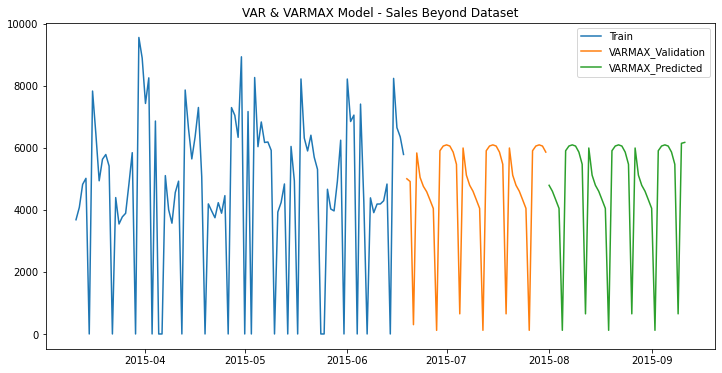

In [158]:
# Predict future values
prediction = varmax_res.forecast(steps=train.shape[0], exog=train[['Promo','Open','DayOfWeek']])

df_test_pred_varmax = pd.DataFrame(sales_scaler.inverse_transform(prediction[['Sales_li']])).rename(columns={0:'Sales_li'}).set_index(prediction.index)
df_test_pred_varmax = df_test_pred_varmax.loc[end_index+relativedelta(days=1):test_index]

# visualizing the data generated for the next 6 weeks BEYOND the dataset
plt.figure(figsize=(12,6)) 
plt.plot(train['Sales'][-100:], label='Train')
plt.plot(df_pred_varmax['Sales_li'], label='VARMAX_Validation')
plt.plot(df_test_pred_varmax['Sales_li'], label='VARMAX_Predicted')
plt.legend(loc='best')
plt.title('VAR & VARMAX Model - Sales Beyond Dataset')
plt.show()